# Curved Volume on Triangulated Surfaces — Notebook Overview

> This notebook computes **curved volumes** on a triangulated surface by  
> (1) fitting/normalizing **quadric surfaces** per vertex,  
> (2) transforming geometry to **canonical frames**,  
> (3) evaluating **curved patch volumes** (solid-angle / swept-segment), and  
> (4) **thickness-weighted splitting** back to vertices.  
> Results are validated against analytic volumes (e.g., ellipsoids).

---

## What this notebook does

1. **Fit local quadrics** at mesh vertices  
   Each vertex gets coefficients for the quadratic surface:

   $$
   f(x,y,z)=A x^2+B y^2+C z^2+Dxy+Exz+Fyz+Gx+Hy+Iz+J=0.
   $$

   Small coefficients are regularized; “smart normalization” prefers \(J=-1\) when stable, otherwise \(H=+1\) for paraboloid-like cases.

2. **Canonicalize & transform**  
   Translate to the local center, rotate to principal axes, and **post-scale** to unitized space:

   $$
   \mathbf{p}'=\mathbf{R}^{\top}(\mathbf{p}-\mathbf{c}), \qquad
   \mathbf{p}''=\mathbf{p}' \oslash \text{scale\_factors1}.
   $$

   Detect surface type (ellipsoid / cylinder / paraboloid / hyperboloid) and snap parameters for robust downstream formulas.

3. **Compute curved patch volumes** for each triangle  
   Use **solid-angle wedge volumes** on the unit sphere and/or **swept-segment** / axisymmetric formulas.  
   Combine wedge/cap corrections to obtain the **curved volume correction** relative to the flat tetrahedral reference.

4. **Thickness-weighted split to vertices**  
   Split each triangle’s curved volume into (A,B,C) contributions with a **thickness-weighted rule**, improving conservation and stability on irregular meshes.

5. **Aggregate & validate**  
   Sum per-triangle (and per-vertex) volumes.  
   Compare to ground truth (e.g. ellipsoid volume) and report relative error.



---

## Key quantities (at a glance)

**Unit-sphere wedge volume**

$$
V_{\text{wedge}}=\Omega/3.
$$

**Ellipsoid check**

$$
V_{\text{theory}}=\frac{4}{3}\pi a b c.
$$

**Patch split**

$$
V_{\text{patch}}=V_A+V_B+V_C.
$$

---

## How to run (suggested flow)

1. Load mesh & per-vertex coefficients  
2. Transform to canonical space and detect surface types  
3. Compute per-triangle curved volumes and split to vertices  
4. Aggregate totals; compare against analytic references  
5. *(Optional)* Plot selected triangles/patches for sanity checks

> **Outputs you’ll see:**  
> • CSVs like `*_COEFFS_Transformed.csv`, `*_Volume.csv` (per-triangle and per-vertex fields)  
> • Console summaries (e.g., patch totals, relative errors)  
> • Optional figures for mesh/patch diagnostics

---

## File map (modules used here)

- `_1_coeffs_computing.py` — Per-vertex quadric fitting + smart normalization  
- `_2_quadric_transformer.py` — Center/rotate/scale transforms, surface-type detection, post-scaled coeffs  
- `_3_1_translation_curved_volume_computing.py` — Triangle curved volume (solid angle / caps / corrections)  
- `_3_2_shared_translation_conic_utils.py` — Shared conic/quadric helpers (projection, canonical params)  
- `_3_3_swept_segment_volume_AB.py` — Swept-segment volume between edge endpoints (canonical space)  
- `_3_4_shared_axisymmetric_utils.py` — Axisymmetric shortcuts for revolution surfaces  
- `_3_5_volume_ellipsoid.py` — Analytic ellipsoid volume & consistency checks  
- `_4_dualvolume_split_patch_volume_thickness_weighted.py` — Thickness-weighted \((A,B,C)\) patch volume split  
- `_plot_mesh.py` — Lightweight mesh/patch visualization for QA  
- `main.ipynb` — Orchestrates the full pipeline & produces CSV/plots

---

## Benchmark summary 

| Geometry                 | Relative error |
|--------------------------|---------------:|
| Ellipsoid                | 3.6e-6%        |
| Hyperboloid of one sheet | 0.04%          |
| Elliptic paraboloid      | 0.03%          |
| Parabolic cylinder       | 1e-4%          |
| Hyperbolic cylinder      | 2.7e-4%        |
| Circular cylinder        | 4e-6%          |

**Performance:** computing time is < **0.1 millisecond per tet element**.

---

## Notes & conventions

- All transforms are **reversible**; reported `ABC_new_*` are post-scaled for stable evaluation  
- Solid-angle computations assume **normalized** vertices in the canonical frame  
- Thickness-weighted splitting improves conservation on **high aspect-ratio** triangles  
- Small coefficients are ε-clipped to reduce numerical noise

*If you change mesh scale or axes \((a,b,c)\), re-run from the transform step to keep wedge/cap volumes consistent with the canonicalization.*


## 1. Ellipsoid
## 1.1 Load Ellipsoid Mesh
## 1.2 Fit Local Quadrics (ABC Coefficients)

In [700]:
import subprocess, sys, shlex
from pathlib import Path

HERE   = Path.cwd().resolve()                    # folder containing the notebook, .msh, and script
SCRIPT = (HERE / "_1_coeffs_computing.py").resolve()
MESH   = (HERE / "Ellip_0_sub0_full.msh").resolve()    # <-- change filename if needed
OUT    = (HERE / f"{MESH.stem}_COEFFS.csv").resolve()

print("Script :", SCRIPT)
print("Mesh   :", MESH)
print("Output :", OUT)

if not MESH.exists():
    raise FileNotFoundError(f"Input .msh not found at: {MESH}")

cmd = [sys.executable, str(SCRIPT), "--msh", str(MESH), "--out", str(OUT)]
print("Running:", " ".join(shlex.quote(c) for c in cmd))

res = subprocess.run(cmd, check=True, capture_output=True, text=True)
if res.stdout: print(res.stdout)
if res.stderr: print(res.stderr)
print(f"✅ Done! Output written to {OUT}")


Script : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py
Mesh   : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full.msh
Output : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full_COEFFS.csv
Running: '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/venv/bin/python' '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py' --msh '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full.msh' --out '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full_COEFFS.csv'

[triangles] explicit surface faces: 20 (from 1 block(s))
[mesh] points=12  surface_triangles=20
[smooth] components: 10 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full_COEFFS.csv  (rows kept=20

## 1.3 Ellipsoid Mesh Display

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full.msh

[loaded] Ellip_0_sub0_full.msh
  points: 12
  cells[tetra]: 18
  cells[triangle]: 20
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


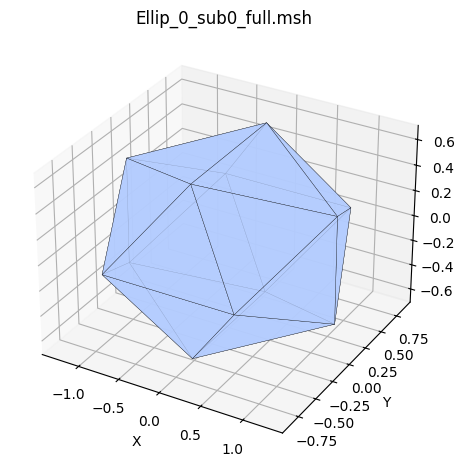

In [701]:
# === Block 2: Display mesh using _plot_mesh.py (uses MESH from Block 1) ===
from pathlib import Path
import importlib.util, sys

PLOT_SCRIPT = (Path.cwd() / "_plot_mesh.py").resolve()
if not PLOT_SCRIPT.exists():
    # fallback if the file lives in /mnt/data
    alt = Path("/mnt/data/_plot_mesh.py")
    if alt.exists():
        PLOT_SCRIPT = alt.resolve()
if not PLOT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _plot_mesh.py in CWD or /mnt/data")

# Dynamically import the plotting helper
spec = importlib.util.spec_from_file_location("plot_mesh_mod", str(PLOT_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules["plot_mesh_mod"] = mod
spec.loader.exec_module(mod)  # type: ignore

# Use MESH from Block 1; fallback to default name if missing
try:
    MESH
except NameError:
    HERE = Path.cwd().resolve()
    MESH = (HERE / "Ellip_0_sub0_full.msh").resolve()

print("Plotting mesh:", MESH)
mod.show_mesh(MESH)


## 1.4 Canonicalize & Transform (CAU)

In [702]:
from pathlib import Path
import importlib.util, sys, pandas as pd

# Locate transformer script
HERE = Path.cwd().resolve()
CANDIDATES = [
    HERE / "_2_quadric_transformer.py",
    Path("/mnt/data/_2_quadric_transformer.py"),
]
TF_SCRIPT = next((p for p in CANDIDATES if p.exists()), None)
if TF_SCRIPT is None:
    raise FileNotFoundError("Could not find _2_quadric_transformer.py next to the notebook or in /mnt/data")

# Resolve input CSV (use OUT from previous block if available)
try:
    csv_in = Path(OUT).resolve()
except NameError:
    candidates = sorted(HERE.glob("*_COEFFS.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No *_COEFFS.csv found. Run the previous block first or set OUT.")
    csv_in = candidates[0]

print("Transformer script:", TF_SCRIPT)
print("Input CSV         :", csv_in)

# Dynamic import — ensure the module is registered BEFORE exec_module (fixes @dataclass issue)
spec = importlib.util.spec_from_file_location("quadric_tf", str(TF_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = mod  # <-- critical line
spec.loader.exec_module(mod)  # type: ignore

# Transform one file
out_csv, err_csv, n_err = mod.process_file(str(csv_in))
print("Wrote:", out_csv)
if n_err:
    print(f"Errors: {n_err} -> {err_csv}")

# Preview transformed output
df_t = pd.read_csv(out_csv)
print("Transformed rows:", len(df_t), "| Columns:", len(df_t.columns))
display(df_t.head(10))


Transformer script: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_2_quadric_transformer.py
Input CSV         : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full_COEFFS.csv
Wrote: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full_COEFFS_Transformed.csv
Transformed rows: 20 | Columns: 26


triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
0            0     4     9    10               0.8               1.0   
1            1     9    10    11               0.8               1.0   
2            2     1     7     8               0.8               1.0   
3            3     1     2     7               0.8               1.0   
4            4     2     6     7               0.8               1.0   
5            5     6     7    11               0.8               1.0   
6            6     4     5     9               0.8               1.0   
7            7     0     4     5               0.8               1.0   
8            8     3     4    10               0.8               1.0   
9            9     5     8     9               0.8               1.0   

   scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
0               1.5        -0.850651         0.525731         0.000000  ...   
1               1.5        -0.850651        -0.525731         0.000000  ...   
2               1.5         0.525731         0.000000         0.850651  ...   
3               1.5         0.525731         0.000000         0.850651  ...   
4               1.5         0.850651         0.525731         0.000000  ...   
5               1.5         0.525731         0.000000        -0.850651  ...   
6               1.5        -0.850651         0.525731         0.000000  ...   
7               1.5         0.000000         0.850651         0.525731  ...   
8               1.5         0.000000         0.850651        -0.525731  ...   
9               1.5        -0.525731         0.000000         0.850651  ...   

   ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
0          1          1          1          0          0          0   
1          1          1          1          0          0          0   
2          1          1          1          0          0          0   
3          1          1          1          0          0          0   
4          1          1          1          0          0          0   
5          1          1          1          0          0          0   
6          1          1          1          0          0          0   
7          1          1          1          0          0          0   
8          1          1          1          0          0          0   
9          1          1          1          0          0          0   

   ABC_new_G  ABC_new_H  ABC_new_I  ABC_new_J  
0          0          0          0         -1  
1          0          0          0         -1  
2          0          0          0         -1  
3          0          0          0         -1  
4          0          0          0         -1  
5          0          0          0         -1  
6          0          0          0         -1  
7          0          0          0         -1  
8          0          0          0         -1  
9          0          0          0         -1  

[10 rows x 26 columns]

## 1.5 Curved Patch Volume (Wedge / Swept-Segment)
## 1.6 Thickness-Weighted Split (A, B, C)
## 1.7 Aggregate Volume & Relative Error
## 1.8 Save Outputs

In [703]:
# === Row-by-row volume engine → writes "<basename>_Volume.csv" (no __ELL files) ===
import sys, importlib.util, tempfile, os, time
from pathlib import Path
import pandas as pd
import numpy as np

TOL = 1e-9
HERE = Path.cwd().resolve()
t0 = time.time()

# 1) get transformed CSV from previous block
try:
    INPUT_T = Path(out_csv).resolve()   # set by transform cell
except NameError:
    cands = sorted(HERE.glob("*_COEFFS_Transformed.csv"),
                   key=lambda p: p.stat().st_mtime, reverse=True)
    if not cands:
        raise FileNotFoundError("No *_COEFFS_Transformed.csv found. Run the transform block first.")
    INPUT_T = cands[0]

print("Row-by-row input:", INPUT_T)

# 2) read & classify each row
df = pd.read_csv(INPUT_T)

def pick(colnames):
    for c in colnames:
        if c in df.columns: return c
    return None

Acol = pick(["ABC_new_A","ABC_A"]); Bcol = pick(["ABC_new_B","ABC_B"]); Ccol = pick(["ABC_new_C","ABC_C"])
Ecol = pick(["ABC_new_E","ABC_E"]); Fcol = pick(["ABC_new_F","ABC_F"]); Icol = pick(["ABC_new_I","ABC_I"])
Jcol = pick(["ABC_new_J","ABC_J"])
needed = [Acol,Bcol,Ccol,Ecol,Fcol,Icol,Jcol]
if any(c is None for c in needed):
    missing = [n for c,n in zip(needed,["A","B","C","E","F","I","J"]) if c is None]
    raise ValueError(f"Missing coefficient columns: {missing}")

A = df[Acol].to_numpy(); B = df[Bcol].to_numpy(); C = df[Ccol].to_numpy()
E = df[Ecol].to_numpy(); F = df[Fcol].to_numpy(); I = df[Icol].to_numpy(); J = df[Jcol].to_numpy()

ell_mask = (A > 0) & (B > 0) & (C > 0) & (np.abs(J) > 0)
noz_mask = (np.abs(C) < TOL) & (np.abs(E) < TOL) & (np.abs(F) < TOL) & (np.abs(I) < TOL)
axis_mask = ~(ell_mask | noz_mask)

print(f"Counts → ellipsoid: {int(ell_mask.sum())}, translation(no-z): {int(noz_mask.sum())}, axisymmetric: {int(axis_mask.sum())}")

# 3) util: import module from file safely (@dataclass friendly)
def import_module(script_path: Path, name: str):
    spec = importlib.util.spec_from_file_location(name, str(script_path))
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod
    spec.loader.exec_module(mod)  # type: ignore
    return mod

def find_script(name: str) -> Path:
    p1 = HERE / name
    p2 = Path("/mnt/data") / name
    if p1.exists(): return p1.resolve()
    if p2.exists(): return p2.resolve()
    raise FileNotFoundError(f"Script not found: {name}")

# 4) run per-category in a TEMP directory; merge results; keep only final <base>_Volume.csv
final_out = Path(INPUT_T.with_suffix("").as_posix() + "_Volume.csv")
parts = []

with tempfile.TemporaryDirectory() as td:
    TMP = Path(td)

    # write subsets into temp only (no __ELL/TRN/ROT in CWD)
    def write_subset(mask, fname):
        if mask.any():
            path = TMP / fname
            df.loc[mask].to_csv(path, index=False)
            return path
        return None

    p_ell = write_subset(ell_mask, "ell.csv")
    p_trn = write_subset(noz_mask, "trn.csv")
    p_rot = write_subset(axis_mask, "rot.csv")

    # ELLIPSOID: _3_5_volume_ellipsoid.py (function API)
    if p_ell is not None:
        m = import_module(find_script("_3_5_volume_ellipsoid.py"), "vol_ell")
        out_csv_ell, curved_count_ell, planar_skipped_ell, V_sum_ell = m.process_coeffs_transformed_csv(str(p_ell))
        parts.append(Path(out_csv_ell))

    # TRANSLATION: All_Translation_Volume_Transformed.py (CLI-style main)
    if p_trn is not None:
        m = import_module(find_script("All_Translation_Volume_Transformed.py"), "vol_trn")
        argv_bak = sys.argv[:]
        try:
            sys.argv = ["All_Translation_Volume_Transformed.py", str(p_trn)]
            m.main()
        finally:
            sys.argv = argv_bak
        parts.append(Path(str(p_trn.with_suffix('')) + "_Volume.csv"))

    # AXISYMMETRIC: All_Rotation_Volume_Transformed_v2.py (CLI-style main)
    if p_rot is not None:
        m = import_module(find_script("All_Rotation_Volume_Transformed_v2.py"), "vol_rot")
        argv_bak = sys.argv[:]
        try:
            sys.argv = ["All_Rotation_Volume_Transformed_v2.py", str(p_rot)]
            m.main()
        finally:
            sys.argv = argv_bak
        parts.append(Path(str(p_rot.with_suffix('')) + "_Volume.csv"))

    # read & merge parts
    dfs = []
    for p in parts:
        if not p.exists():
            raise FileNotFoundError(f"Expected temp volume file missing: {p}")
        dfs.append(pd.read_csv(p))
    df_all = pd.concat(dfs, ignore_index=True)

# reorder columns if core present
core_cols = [
    "triangle_id","Vcorrection",
    "V_patch_A","V_patch_B","V_patch_C",
    "scaling_factor","Vcorrection_scal",
    "V_patch_A_scal","V_patch_B_scal","V_patch_C_scal",
    "side",
]
if all(c in df_all.columns for c in core_cols):
    df_all = df_all[core_cols]
if "triangle_id" in df_all.columns:
    df_all = df_all.sort_values("triangle_id").reset_index(drop=True)

df_all.to_csv(final_out, index=False)

# ---- summary prints you requested ----
t1 = time.time()
curved_count = len(df_all)
planar_skipped = int(np.sum(df_all["side"].astype(str).str.contains("planar", case=False, na=False))) if "side" in df_all.columns else 0
V_sum = float(np.nansum(df_all["Vcorrection"].values)) if "Vcorrection" in df_all.columns else 0.0

#print(f"[input] {INPUT_T}")
#print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")
print("**************************************************")
print("relative error", (5.02654825 - 3.04338074 - V_sum)/5.02654825*100,"%")
print("**************************************************")
print(f"Total elapsed: {t1 - t0:.2f} s")
print(f"[write] {os.path.abspath(final_out)}")

# preview
display(df_all.head(10))


Row-by-row input: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/Ellip_0_sub0_full_COEFFS_Transformed.csv
Counts → ellipsoid: 20, translation(no-z): 0, axisymmetric: 0
[tri 0] ||A||=1.000000000 ||B||=1.000000000 ||C||=1.000000000 | s_to_unit=(1.0, 1.0, 1.0) | det(ellip)=1.199999957
           Omega=0.628318498988  Vw=0.209439499663  Vf=0.126807532083
           Vcor_sphere=0.082631967579  sum(parts_sphere)=0.082631967579
           Vcor_ellip =0.099158357562  sum(parts_ellip) =0.099158357562  side=inward
[tri 1] ||A||=1.000000000 ||B||=1.000000000 ||C||=1.000000000 | s_to_unit=(1.0, 1.0, 1.0) | det(ellip)=1.199999957
           Omega=0.628318529488  Vw=0.209439509829  Vf=0.126807535373
           Vcor_sphere=0.082631974456  sum(parts_sphere)=0.082631974456
           Vcor_ellip =0.099158365814  sum(parts_ellip) =0.099158365814  side=outward
[tri 2] ||A||=1.000000000 ||B||=1.000000000 ||C||=1.000000000 | s_to_unit=(1.0, 1.0, 1.0) | det(ellip)=1.199999957
   

triangle_id  Vcorrection  V_patch_A  V_patch_B  V_patch_C  scaling_factor  \
0            0     0.099158   0.031121   0.031121   0.036916             1.2   
1            1     0.099158   0.026779   0.035876   0.036503             1.2   
2            2     0.099158   0.035876   0.026779   0.036503             1.2   
3            3     0.099158   0.036916   0.031121   0.031121             1.2   
4            4     0.099158   0.031121   0.036916   0.031121             1.2   
5            5     0.099158   0.035876   0.026779   0.036503             1.2   
6            6     0.099158   0.031121   0.036916   0.031121             1.2   
7            7     0.099158   0.036503   0.026779   0.035876             1.2   
8            8     0.099158   0.036503   0.026779   0.035876             1.2   
9            9     0.099158   0.035876   0.036503   0.026779             1.2   

   Vcorrection_scal  V_patch_A_scal  V_patch_B_scal  V_patch_C_scal     side  
0          0.082632        0.025934        0.025934        0.030763   inward  
1          0.082632        0.022316        0.029897        0.030419  outward  
2          0.082632        0.029897        0.022316        0.030419   inward  
3          0.082632        0.030763        0.025934        0.025934   inward  
4          0.082632        0.025934        0.030763        0.025934   inward  
5          0.082632        0.029897        0.022316        0.030419  outward  
6          0.082632        0.025934        0.030763        0.025934   inward  
7          0.082632        0.030419        0.022316        0.029897  outward  
8          0.082632        0.030419        0.022316        0.029897   inward  
9          0.082632        0.029897        0.030419        0.022316   inward

## 2. Hyperboloid
## 2.1 Load Hyperboloid Mesh
## 2.2 Fit Local Quadrics (ABC Coefficients)

In [704]:
import subprocess, sys, shlex
from pathlib import Path

HERE   = Path.cwd().resolve()                    # folder containing the notebook, .msh, and script
SCRIPT = (HERE / "_1_coeffs_computing.py").resolve()
MESH   = (HERE / "coarse_hyperboloid.msh").resolve()    # <-- change filename if needed
OUT    = (HERE / f"{MESH.stem}_COEFFS.csv").resolve()

print("Script :", SCRIPT)
print("Mesh   :", MESH)
print("Output :", OUT)

if not MESH.exists():
    raise FileNotFoundError(f"Input .msh not found at: {MESH}")

cmd = [sys.executable, str(SCRIPT), "--msh", str(MESH), "--out", str(OUT)]
print("Running:", " ".join(shlex.quote(c) for c in cmd))

res = subprocess.run(cmd, check=True, capture_output=True, text=True)
if res.stdout: print(res.stdout)
if res.stderr: print(res.stderr)
print(f"✅ Done! Output written to {OUT}")

Script : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py
Mesh   : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid.msh
Output : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS.csv
Running: '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/venv/bin/python' '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py' --msh '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid.msh' --out '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS.csv'

[triangles] explicit surface faces: 238 (from 3 block(s))
[mesh] points=129  surface_triangles=238
[smooth] components: 3 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS.csv  (rows 

## 2.3 Display Hyperboloid Mesh

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid.msh

[loaded] coarse_hyperboloid.msh
  points: 129
  cells[triangle]: 57
  cells[triangle]: 124
  cells[triangle]: 57
  cells[tetra]: 355
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


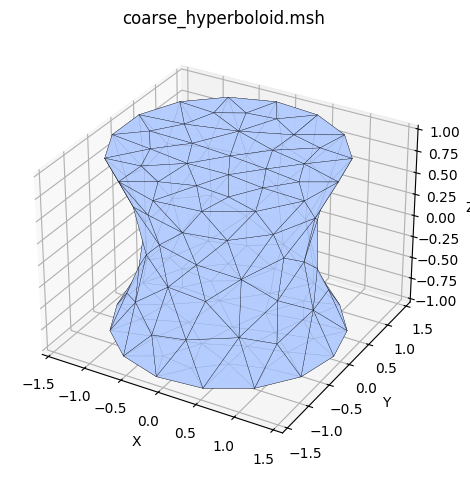

In [705]:
# === Block 2: Display mesh using _plot_mesh.py (uses MESH from Block 1) ===
from pathlib import Path
import importlib.util, sys

PLOT_SCRIPT = (Path.cwd() / "_plot_mesh.py").resolve()
if not PLOT_SCRIPT.exists():
    # fallback if the file lives in /mnt/data
    alt = Path("/mnt/data/_plot_mesh.py")
    if alt.exists():
        PLOT_SCRIPT = alt.resolve()
if not PLOT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _plot_mesh.py in CWD or /mnt/data")

# Dynamically import the plotting helper
spec = importlib.util.spec_from_file_location("plot_mesh_mod", str(PLOT_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules["plot_mesh_mod"] = mod
spec.loader.exec_module(mod)  # type: ignore

# Use MESH from Block 1; fallback to default name if missing
try:
    MESH
except NameError:
    HERE = Path.cwd().resolve()
    MESH = (HERE / "Ellip_0_sub0_full.msh").resolve()

print("Plotting mesh:", MESH)
mod.show_mesh(MESH)


## 2.4 Canonicalize & Transform

In [706]:
from pathlib import Path
import importlib.util, sys, pandas as pd

# Locate transformer script
HERE = Path.cwd().resolve()
CANDIDATES = [
    HERE / "_2_quadric_transformer.py",
    Path("/mnt/data/_2_quadric_transformer.py"),
]
TF_SCRIPT = next((p for p in CANDIDATES if p.exists()), None)
if TF_SCRIPT is None:
    raise FileNotFoundError("Could not find _2_quadric_transformer.py next to the notebook or in /mnt/data")

# Resolve input CSV (use OUT from previous block if available)
try:
    csv_in = Path(OUT).resolve()
except NameError:
    candidates = sorted(HERE.glob("*_COEFFS.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No *_COEFFS.csv found. Run the previous block first or set OUT.")
    csv_in = candidates[0]

print("Transformer script:", TF_SCRIPT)
print("Input CSV         :", csv_in)

# Dynamic import — ensure the module is registered BEFORE exec_module (fixes @dataclass issue)
spec = importlib.util.spec_from_file_location("quadric_tf", str(TF_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = mod  # <-- critical line
spec.loader.exec_module(mod)  # type: ignore

# Transform one file
out_csv, err_csv, n_err = mod.process_file(str(csv_in))
print("Wrote:", out_csv)
if n_err:
    print(f"Errors: {n_err} -> {err_csv}")

# Preview transformed output
df_t = pd.read_csv(out_csv)
print("Transformed rows:", len(df_t), "| Columns:", len(df_t.columns))
display(df_t.head(10))


Transformer script: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_2_quadric_transformer.py
Input CSV         : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS.csv
Wrote: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS_Transformed.csv
Transformed rows: 124 | Columns: 26


triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
0           57     0     5     2          1.000002          1.000011   
1           58    18     0     2          0.999993          1.000009   
2           59     4    19     1          1.000002          1.000014   
3           60    32     4     1          1.000004          1.000016   
4           61     3    62     2          1.000003          1.000003   
5           62     2    63     3          1.000005          1.000011   
6           63     5    93     2          0.999996          1.000008   
7           64     2    94    18          0.999987          1.000003   
8           65    62    94     2          0.999988          0.999999   
9           66     2    93    63          0.999996          1.000003   

   scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
0          1.000010        -1.414201         0.000000    -1.000005e+00  ...   
1          1.000008         1.393921        -0.238697    -1.000008e+00  ...   
2          1.000009         1.123646        -0.132399     5.292882e-01  ...   
3          1.000010        -1.385557         0.283155     1.000008e+00  ...   
4          1.000006         0.000000         0.999997     2.682781e-15  ...   
5          1.000009        -0.587447        -0.966962    -5.292720e-01  ...   
6          1.000007        -1.291943        -0.575208    -1.000008e+00  ...   
7          1.000003         1.110295         0.217711    -5.292862e-01  ...   
8          1.000003         0.990605        -0.293414    -2.595413e-01  ...   
9          1.000007        -1.131431         0.000002    -5.292778e-01  ...   

   ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
0          1          1         -1          0          0          0   
1          1          1         -1          0          0          0   
2          1          1         -1          0          0          0   
3          1          1         -1          0          0          0   
4          1          1         -1          0          0          0   
5          1          1         -1          0          0          0   
6          1          1         -1          0          0          0   
7          1          1         -1          0          0          0   
8          1          1         -1          0          0          0   
9          1          1         -1          0          0          0   

   ABC_new_G  ABC_new_H  ABC_new_I  ABC_new_J  
0        0.0        0.0   0.000000         -1  
1        0.0        0.0  -0.000054         -1  
2        0.0        0.0   0.000068         -1  
3        0.0        0.0   0.000068         -1  
4        0.0        0.0   0.000000         -1  
5        0.0        0.0   0.000000         -1  
6        0.0        0.0   0.000000         -1  
7        0.0        0.0   0.000000         -1  
8        0.0        0.0   0.000000         -1  
9        0.0        0.0   0.000000         -1  

[10 rows x 26 columns]

## 2.5 Curved Patch Volume (Wedge / Swept-Segment)
## 2.6 Thickness-Weighted Split (A, B, C)
## 2.7 Aggregate Volume & Relative Error
## 2.8 Save Outputs

In [707]:
# === Block: Enforce thickness-weighted split on *_Volume.csv (coarse_hyperboloid) ===
import sys, importlib.util, os, time, tempfile
from pathlib import Path
import pandas as pd
import numpy as np

t0 = time.time()
HERE = Path.cwd().resolve()

# -----------------------------------------------------------------------------------
# 1) Resolve files: use previous block's out_csv if present; otherwise fall back to
#    coarse_hyperboloid_COEFFS_Transformed.csv in the current folder.
# -----------------------------------------------------------------------------------
if 'out_csv' in globals():
    TR_CSV = Path(out_csv).resolve()
else:
    TR_CSV = (HERE / "coarse_hyperboloid_COEFFS_Transformed.csv").resolve()

if not TR_CSV.exists():
    raise FileNotFoundError(f"Transformed CSV not found: {TR_CSV}")

VOL_CSV = TR_CSV.with_name(TR_CSV.stem + "_Volume.csv")

print("[split] Transformed CSV:", TR_CSV)
print("[split] Volume CSV     :", VOL_CSV)

# -----------------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------------
def import_module(script_path: Path, name: str):
    spec = importlib.util.spec_from_file_location(name, str(script_path))
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod  # important for decorators like @dataclass
    spec.loader.exec_module(mod)  # type: ignore
    return mod

def find_script(name: str) -> Path:
    p1 = HERE / name
    p2 = Path("/mnt/data") / name
    if p1.exists(): return p1.resolve()
    if p2.exists(): return p2.resolve()
    raise FileNotFoundError(f"Script not found: {name}")

def pick(df: pd.DataFrame, names):
    for n in names:
        if n in df.columns: return n
    return None

# -----------------------------------------------------------------------------------
# 2) If the Volume CSV for this transformed file doesn't exist yet, generate it now
#    using the same row-by-row routing logic as the volume block.
# -----------------------------------------------------------------------------------
if not VOL_CSV.exists():
    print("Volume CSV missing — generating it now:", VOL_CSV.name)
    df_src = pd.read_csv(TR_CSV)

    Acol = pick(df_src, ["ABC_new_A","ABC_A"]); Bcol = pick(df_src, ["ABC_new_B","ABC_B"]); Ccol = pick(df_src, ["ABC_new_C","ABC_C"])
    Ecol = pick(df_src, ["ABC_new_E","ABC_E"]); Fcol = pick(df_src, ["ABC_new_F","ABC_F"]); Icol = pick(df_src, ["ABC_new_I","ABC_I"])
    Jcol = pick(df_src, ["ABC_new_J","ABC_J"])
    needed = [Acol,Bcol,Ccol,Ecol,Fcol,Icol,Jcol]
    if any(c is None for c in needed):
        miss = [n for c,n in zip(needed,["A","B","C","E","F","I","J"]) if c is None]
        raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

    A = df_src[Acol].to_numpy(); B = df_src[Bcol].to_numpy(); C = df_src[Ccol].to_numpy()
    E = df_src[Ecol].to_numpy(); F = df_src[Fcol].to_numpy(); I = df_src[Icol].to_numpy(); J = df_src[Jcol].to_numpy()

    TOL = 1e-9
    ell_mask = (A > 0) & (B > 0) & (C > 0) & (np.abs(J) > 0)
    noz_mask = (np.abs(C) < TOL) & (np.abs(E) < TOL) & (np.abs(F) < TOL) & (np.abs(I) < TOL)
    axis_mask = ~(ell_mask | noz_mask)

    parts = []
    with tempfile.TemporaryDirectory() as td:
        TMP = Path(td)

        def write_subset(mask, fname):
            if mask.any():
                p = TMP / fname
                df_src.loc[mask].to_csv(p, index=False)
                return p
            return None

        p_ell = write_subset(ell_mask, "ell.csv")
        p_trn = write_subset(noz_mask, "trn.csv")
        p_rot = write_subset(axis_mask, "rot.csv")

        # ellipsoid
        if p_ell is not None:
            m = import_module(find_script("_3_5_volume_ellipsoid.py"), "vol_ell")
            out_csv_ell, _, _, _ = m.process_coeffs_transformed_csv(str(p_ell))
            parts.append(Path(out_csv_ell))

        # translation (writes to CWD)
        if p_trn is not None:
            m = import_module(find_script("All_Translation_Volume_Transformed.py"), "vol_trn")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Translation_Volume_Transformed.py", str(p_trn)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_trn.stem}_Volume.csv")

        # axisymmetric (writes to CWD)
        if p_rot is not None:
            m = import_module(find_script("All_Rotation_Volume_Transformed_v2.py"), "vol_rot")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Rotation_Volume_Transformed_v2.py", str(p_rot)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_rot.stem}_Volume.csv")

        dfs = []
        for p in parts:
            if not p.exists():
                raise FileNotFoundError(f"Expected temp volume file missing: {p}")
            dfs.append(pd.read_csv(p))
        pd.concat(dfs, ignore_index=True).to_csv(VOL_CSV, index=False)

    print("Generated:", VOL_CSV)

# -----------------------------------------------------------------------------------
# 3) Load the final Volume CSV and the transformed CSV (for geometry + coeffs)
# -----------------------------------------------------------------------------------
df_vol = pd.read_csv(VOL_CSV)
df_tr  = pd.read_csv(TR_CSV)

# Ensure triangle_id types align
if "triangle_id" not in df_vol.columns or "triangle_id" not in df_tr.columns:
    raise ValueError("Both CSVs must contain 'triangle_id'.")
df_vol["triangle_id"] = pd.to_numeric(df_vol["triangle_id"], errors="raise").astype(int)
df_tr["triangle_id"]  = pd.to_numeric(df_tr["triangle_id"], errors="raise").astype(int)

# Columns we need from the transformed CSV
coef_cols = {
    "A": pick(df_tr, ["ABC_new_A","ABC_A"]),
    "B": pick(df_tr, ["ABC_new_B","ABC_B"]),
    "C": pick(df_tr, ["ABC_new_C","ABC_C"]),
    "D": pick(df_tr, ["ABC_new_D","ABC_D"]),
    "E": pick(df_tr, ["ABC_new_E","ABC_E"]),
    "F": pick(df_tr, ["ABC_new_F","ABC_F"]),
    "G": pick(df_tr, ["ABC_new_G","ABC_G"]),
    "H": pick(df_tr, ["ABC_new_H","ABC_H"]),
    "I": pick(df_tr, ["ABC_new_I","ABC_I"]),
    "J": pick(df_tr, ["ABC_new_J","ABC_J"]),
}
if any(v is None for v in coef_cols.values()):
    miss = [k for k,v in coef_cols.items() if v is None]
    raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

pt_cols = [
    "A_transformed_x","A_transformed_y","A_transformed_z",
    "B_transformed_x","B_transformed_y","B_transformed_z",
    "C_transformed_x","C_transformed_y","C_transformed_z",
]
if not all(c in df_tr.columns for c in pt_cols):
    raise ValueError(f"Transformed CSV missing required point columns: {set(pt_cols) - set(df_tr.columns)}")

# scaling: prefer 'scaling_factor'; else product(scale_factors1_*); else 1.0
sc_col = pick(df_tr, ["scaling_factor","scale_factor","jacobian","scale"])
if sc_col is None:
    if all(c in df_tr.columns for c in ["scale_factors1_x","scale_factors1_y","scale_factors1_z"]):
        df_tr["__scaling__"] = (
            pd.to_numeric(df_tr["scale_factors1_x"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_y"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_z"], errors="coerce")
        ).fillna(1.0)
        sc_col = "__scaling__"
    else:
        df_tr["__scaling__"] = 1.0
        sc_col = "__scaling__"

# Merge geometry/coeffs onto volume rows via triangle_id
geom_cols = ["triangle_id", sc_col] + pt_cols + list(coef_cols.values())
df = df_vol.merge(df_tr[geom_cols], on="triangle_id", how="left", suffixes=("", "_geom"))

# If some rows lack geometry, just skip recomputing for them (leave as-is)
row_has_geom = ~df[pt_cols].isna().any(axis=1)
miss_cnt = int((~row_has_geom).sum())
if miss_cnt:
    sample = df.loc[~row_has_geom, "triangle_id"].head(8).tolist()
    print(f"⚠️ {miss_cnt} rows in Volume have no matching geometry/coeffs (examples: {sample}). "
          f"They will be left unchanged.")

# -----------------------------------------------------------------------------------
# 4) Load thickness-weighted splitter and recompute patches on matched rows
# -----------------------------------------------------------------------------------
SPLIT_SCRIPT = (HERE / "_4_dualvolume_split_patch_volume_thickness_weighted.py")
if not SPLIT_SCRIPT.exists():
    alt = Path("/mnt/data/_4_dualvolume_split_patch_volume_thickness_weighted.py")
    if alt.exists(): SPLIT_SCRIPT = alt
if not SPLIT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _4_dualvolume_split_patch_volume_thickness_weighted.py")

split_mod = import_module(SPLIT_SCRIPT, "split_mod")
split_fn = getattr(split_mod, "split_patch_volume_thickness_weighted", None)
if split_fn is None:
    raise AttributeError("split_patch_volume_thickness_weighted not found in splitter module.")

vA_list, vB_list, vC_list = [], [], []
vAs_list, vBs_list, vCs_list = [], [], []
tri_list = []
repaired = 0

df_work = df.loc[row_has_geom].copy()
for _, row in df_work.iterrows():
    V = float(row.get("Vcorrection", 0.0))
    Axyz = np.array([row["A_transformed_x"], row["A_transformed_y"], row["A_transformed_z"]], float)
    Bxyz = np.array([row["B_transformed_x"], row["B_transformed_y"], row["B_transformed_z"]], float)
    Cxyz = np.array([row["C_transformed_x"], row["C_transformed_y"], row["C_transformed_z"]], float)
    coeffs = tuple(float(row[coef_cols[k]]) for k in ["A","B","C","D","E","F","G","H","I","J"])
    s = float(row[sc_col]) if np.isfinite(row[sc_col]) else 1.0

    try:
        vA, vB, vC = split_fn(V, Axyz, Bxyz, Cxyz, coeffs, eps=1e-12)
        S = vA + vB + vC
        if not np.isfinite(S) or abs(S) < 1e-30:
            raise ValueError("ill-conditioned sum")
        scale = V / S if S != 0 else 0.0
        vA *= scale; vB *= scale; vC = V - vA - vB
    except Exception:
        repaired += 1
        vA = vB = vC = V / 3.0

    tri_list.append(int(row["triangle_id"]))
    vA_list.append(vA); vB_list.append(vB); vC_list.append(vC)
    vAs_list.append(vA * s); vBs_list.append(vB * s); vCs_list.append(vC * s)

# Write recomputed values back (matched rows only)
if tri_list:
    df_vol = df_vol.set_index("triangle_id")
    df_tmp = pd.DataFrame({
        "triangle_id": tri_list,
        "V_patch_A": vA_list, "V_patch_B": vB_list, "V_patch_C": vC_list,
        "V_patch_A_scal": vAs_list, "V_patch_B_scal": vBs_list, "V_patch_C_scal": vCs_list,
    }).set_index("triangle_id")
    df_vol.update(df_tmp)
    df_vol = df_vol.reset_index()

# Always recompute sums from current patches
if {"V_patch_A","V_patch_B","V_patch_C"}.issubset(df_vol.columns):
    df_vol["Vcorrection"] = df_vol[["V_patch_A","V_patch_B","V_patch_C"]].sum(axis=1)
if {"V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"}.issubset(df_vol.columns):
    df_vol["Vcorrection_scal"] = df_vol[["V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"]].sum(axis=1)

# Save
df_vol.to_csv(VOL_CSV, index=False)

# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format)
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")
print("**************************************************")
print("relative error", ( 8.30147792 + V_sum - 8.37758041)/8.37758041*100,"%")
print("**************************************************")
print(f"Total elapsed: {t1 - t0:.2f} s")
print(f"[write] {os.path.abspath(VOL_CSV)}")

display(df_vol.head(10))


[split] Transformed CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS_Transformed.csv
[split] Volume CSV     : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS_Transformed_Volume.csv
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS_Transformed.csv
Triangles written: 124 | (degenerate≈zero) flagged: 0 | recomputed rows=124 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.07943469
**************************************************
relative error 0.039775164213277876 %
**************************************************
Total elapsed: 0.08 s
[write] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_hyperboloid_COEFFS_Transformed_Volume.csv


triangle_id  Vcorrection  V_patch_A  V_patch_B  V_patch_C  scaling_factor  \
0           57     0.001290   0.000455   0.000446   0.000389        1.000022   
1           58     0.001290   0.000440   0.000458   0.000392        1.000010   
2           59     0.001290   0.000390   0.000443   0.000456        1.000025   
3           60     0.001290   0.000440   0.000392   0.000458        1.000030   
4           61     0.000588   0.000180   0.000159   0.000249        1.000012   
5           62     0.000384   0.000170   0.000100   0.000114        1.000025   
6           63     0.002367   0.000934   0.000776   0.000657        1.000011   
7           64     0.001394   0.000401   0.000452   0.000540        0.999993   
8           65     0.002195   0.000677   0.000849   0.000668        0.999990   
9           66     0.002764   0.000816   0.001052   0.000895        1.000007   

   Vcorrection_scal  V_patch_A_scal  V_patch_B_scal  V_patch_C_scal    side  
0          0.001290        0.000455        0.000446        0.000389  inward  
1          0.001290        0.000440        0.000458        0.000392  inward  
2          0.001290        0.000390        0.000443        0.000456  inward  
3          0.001290        0.000440        0.000392        0.000458  inward  
4          0.000588        0.000180        0.000159        0.000249  inward  
5          0.000384        0.000170        0.000100        0.000114  inward  
6          0.002367        0.000934        0.000776        0.000657  inward  
7          0.001394        0.000401        0.000452        0.000540  inward  
8          0.002194        0.000677        0.000849        0.000668  inward  
9          0.002764        0.000816        0.001052        0.000895  inward

## 3. Parabolic Cylinder
## 3.1 Load Parabolic Cylinder Mesh
## 3.2 Fit Local Quadrics (ABC Coefficients)

In [708]:
import subprocess, sys, shlex
from pathlib import Path

HERE   = Path.cwd().resolve()                    # folder containing the notebook, .msh, and script
SCRIPT = (HERE / "_1_coeffs_computing.py").resolve()
MESH   = (HERE / "parabolic_cylinder_y_eq_x2_y1slice.msh").resolve()    # <-- change filename if needed
OUT    = (HERE / f"{MESH.stem}_COEFFS.csv").resolve()

print("Script :", SCRIPT)
print("Mesh   :", MESH)
print("Output :", OUT)

if not MESH.exists():
    raise FileNotFoundError(f"Input .msh not found at: {MESH}")

cmd = [sys.executable, str(SCRIPT), "--msh", str(MESH), "--out", str(OUT)]
print("Running:", " ".join(shlex.quote(c) for c in cmd))

res = subprocess.run(cmd, check=True, capture_output=True, text=True)
if res.stdout: print(res.stdout)
if res.stderr: print(res.stderr)
print(f"✅ Done! Output written to {OUT}")

Script : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py
Mesh   : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice.msh
Output : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice_COEFFS.csv
Running: '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/venv/bin/python' '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py' --msh '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice.msh' --out '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice_COEFFS.csv'

[triangles] explicit surface faces: 266 (from 9 block(s))
[mesh] points=135  surface_triangles=266
[smooth] components: 5 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgcli

## 1.3 Parabolic Cylinder Mesh Display

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice.msh

[loaded] parabolic_cylinder_y_eq_x2_y1slice.msh
  points: 135
  cells[triangle]: 52
  cells[triangle]: 26
  cells[triangle]: 26
  cells[triangle]: 21
  cells[triangle]: 21
  cells[triangle]: 42
  cells[triangle]: 52
  cells[triangle]: 13
  cells[triangle]: 13
  cells[tetra]: 271
  cells[tetra]: 149
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


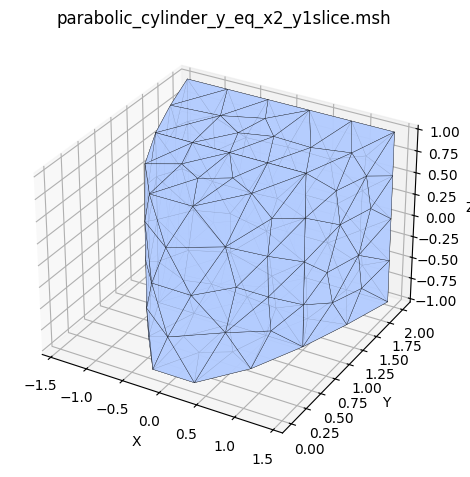

In [709]:
# === Block 2: Display mesh using _plot_mesh.py (uses MESH from Block 1) ===
from pathlib import Path
import importlib.util, sys

PLOT_SCRIPT = (Path.cwd() / "_plot_mesh.py").resolve()
if not PLOT_SCRIPT.exists():
    # fallback if the file lives in /mnt/data
    alt = Path("/mnt/data/_plot_mesh.py")
    if alt.exists():
        PLOT_SCRIPT = alt.resolve()
if not PLOT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _plot_mesh.py in CWD or /mnt/data")

# Dynamically import the plotting helper
spec = importlib.util.spec_from_file_location("plot_mesh_mod", str(PLOT_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules["plot_mesh_mod"] = mod
spec.loader.exec_module(mod)  # type: ignore

# Use MESH from Block 1; fallback to default name if missing
try:
    MESH
except NameError:
    HERE = Path.cwd().resolve()
    MESH = (HERE / "Ellip_0_sub0_full.msh").resolve()

print("Plotting mesh:", MESH)
mod.show_mesh(MESH)


## 3.4 Canonicalize & Transform


In [710]:
from pathlib import Path
import importlib.util, sys, pandas as pd

# Locate transformer script
HERE = Path.cwd().resolve()
CANDIDATES = [
    HERE / "_2_quadric_transformer.py",
    Path("/mnt/data/_2_quadric_transformer.py"),
]
TF_SCRIPT = next((p for p in CANDIDATES if p.exists()), None)
if TF_SCRIPT is None:
    raise FileNotFoundError("Could not find _2_quadric_transformer.py next to the notebook or in /mnt/data")

# Resolve input CSV (use OUT from previous block if available)
try:
    csv_in = Path(OUT).resolve()
except NameError:
    candidates = sorted(HERE.glob("*_COEFFS.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No *_COEFFS.csv found. Run the previous block first or set OUT.")
    csv_in = candidates[0]

print("Transformer script:", TF_SCRIPT)
print("Input CSV         :", csv_in)

# Dynamic import — ensure the module is registered BEFORE exec_module (fixes @dataclass issue)
spec = importlib.util.spec_from_file_location("quadric_tf", str(TF_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = mod  # <-- critical line
spec.loader.exec_module(mod)  # type: ignore

# Transform one file
out_csv, err_csv, n_err = mod.process_file(str(csv_in))
print("Wrote:", out_csv)
if n_err:
    print(f"Errors: {n_err} -> {err_csv}")

# Preview transformed output
df_t = pd.read_csv(out_csv)
print("Transformed rows:", len(df_t), "| Columns:", len(df_t.columns))
display(df_t.head(10))


Transformer script: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_2_quadric_transformer.py
Input CSV         : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice_COEFFS.csv
Wrote: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice_COEFFS_Transformed.csv
Transformed rows: 104 | Columns: 26


triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
0           52     0    70     8          1.000005                 1   
1           53    22    70     0          1.000005                 1   
2           54    10    66     1          0.999995                 1   
3           55     1    66    23          0.999995                 1   
4           56     4    67    22          0.999999                 1   
5           57    26    67     4          1.000000                 1   
6           58    23    71     5          0.999998                 1   
7           59     5    71    24          0.999999                 1   
8           60     8    68     9          1.000006                 1   
9           61     8    70    68          0.999990                 1   

   scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
0                 1        -1.414207         2.000000             -1.0  ...   
1                 1        -1.222172         1.493717             -1.0  ...   
2                 1        -1.414220         2.000000              0.5  ...   
3                 1        -1.414220         2.000000              1.0  ...   
4                 1        -1.000001         1.000000             -1.0  ...   
5                 1        -1.000000         1.000000             -0.5  ...   
6                 1        -1.222179         1.493717              1.0  ...   
7                 1        -1.000001         1.000000              1.0  ...   
8                 1        -1.414205         2.000000             -0.5  ...   
9                 1        -1.414228         2.000000             -0.5  ...   

   ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
0         -1          0          0        0.0          0          0   
1         -1          0          0        0.0          0          0   
2         -1          0          0        0.0          0          0   
3         -1          0          0        0.0          0          0   
4         -1          0          0        0.0          0          0   
5         -1          0          0        0.0          0          0   
6         -1          0          0        0.0          0          0   
7         -1          0          0        0.0          0          0   
8         -1          0          0        0.0          0          0   
9         -1          0          0        0.0          0          0   

   ABC_new_G  ABC_new_H  ABC_new_I  ABC_new_J  
0        0.0          1          0          0  
1        0.0          1          0          0  
2        0.0          1          0          0  
3        0.0          1          0          0  
4        0.0          1          0          0  
5        0.0          1          0          0  
6        0.0          1          0          0  
7        0.0          1          0          0  
8        0.0          1          0          0  
9        0.0          1          0          0  

[10 rows x 26 columns]

## 3.5 Curved Patch Volume (Wedge / Swept-Segment)
## 3.6 Thickness-Weighted Split (A, B, C)
## 3.7 Aggregate Volume & Relative Error
## 3.8 Save Outputs

In [711]:
# === Block: Enforce thickness-weighted split on *_Volume.csv (coarse_hyperboloid) ===
import sys, importlib.util, os, time, tempfile
from pathlib import Path
import pandas as pd
import numpy as np

t0 = time.time()
HERE = Path.cwd().resolve()

# -----------------------------------------------------------------------------------
# 1) Resolve files: use previous block's out_csv if present; otherwise fall back to
#    coarse_hyperboloid_COEFFS_Transformed.csv in the current folder.
# -----------------------------------------------------------------------------------
if 'out_csv' in globals():
    TR_CSV = Path(out_csv).resolve()
else:
    TR_CSV = (HERE / "coarse_hyperboloid_COEFFS_Transformed.csv").resolve()

if not TR_CSV.exists():
    raise FileNotFoundError(f"Transformed CSV not found: {TR_CSV}")

VOL_CSV = TR_CSV.with_name(TR_CSV.stem + "_Volume.csv")

print("[split] Transformed CSV:", TR_CSV)
print("[split] Volume CSV     :", VOL_CSV)

# -----------------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------------
def import_module(script_path: Path, name: str):
    spec = importlib.util.spec_from_file_location(name, str(script_path))
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod  # important for decorators like @dataclass
    spec.loader.exec_module(mod)  # type: ignore
    return mod

def find_script(name: str) -> Path:
    p1 = HERE / name
    p2 = Path("/mnt/data") / name
    if p1.exists(): return p1.resolve()
    if p2.exists(): return p2.resolve()
    raise FileNotFoundError(f"Script not found: {name}")

def pick(df: pd.DataFrame, names):
    for n in names:
        if n in df.columns: return n
    return None

# -----------------------------------------------------------------------------------
# 2) If the Volume CSV for this transformed file doesn't exist yet, generate it now
#    using the same row-by-row routing logic as the volume block.
# -----------------------------------------------------------------------------------
if not VOL_CSV.exists():
    print("Volume CSV missing — generating it now:", VOL_CSV.name)
    df_src = pd.read_csv(TR_CSV)

    Acol = pick(df_src, ["ABC_new_A","ABC_A"]); Bcol = pick(df_src, ["ABC_new_B","ABC_B"]); Ccol = pick(df_src, ["ABC_new_C","ABC_C"])
    Ecol = pick(df_src, ["ABC_new_E","ABC_E"]); Fcol = pick(df_src, ["ABC_new_F","ABC_F"]); Icol = pick(df_src, ["ABC_new_I","ABC_I"])
    Jcol = pick(df_src, ["ABC_new_J","ABC_J"])
    needed = [Acol,Bcol,Ccol,Ecol,Fcol,Icol,Jcol]
    if any(c is None for c in needed):
        miss = [n for c,n in zip(needed,["A","B","C","E","F","I","J"]) if c is None]
        raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

    A = df_src[Acol].to_numpy(); B = df_src[Bcol].to_numpy(); C = df_src[Ccol].to_numpy()
    E = df_src[Ecol].to_numpy(); F = df_src[Fcol].to_numpy(); I = df_src[Icol].to_numpy(); J = df_src[Jcol].to_numpy()

    TOL = 1e-9
    ell_mask = (A > 0) & (B > 0) & (C > 0) & (np.abs(J) > 0)
    noz_mask = (np.abs(C) < TOL) & (np.abs(E) < TOL) & (np.abs(F) < TOL) & (np.abs(I) < TOL)
    axis_mask = ~(ell_mask | noz_mask)

    parts = []
    with tempfile.TemporaryDirectory() as td:
        TMP = Path(td)

        def write_subset(mask, fname):
            if mask.any():
                p = TMP / fname
                df_src.loc[mask].to_csv(p, index=False)
                return p
            return None

        p_ell = write_subset(ell_mask, "ell.csv")
        p_trn = write_subset(noz_mask, "trn.csv")
        p_rot = write_subset(axis_mask, "rot.csv")

        # ellipsoid
        if p_ell is not None:
            m = import_module(find_script("_3_5_volume_ellipsoid.py"), "vol_ell")
            out_csv_ell, _, _, _ = m.process_coeffs_transformed_csv(str(p_ell))
            parts.append(Path(out_csv_ell))

        # translation (writes to CWD)
        if p_trn is not None:
            m = import_module(find_script("All_Translation_Volume_Transformed.py"), "vol_trn")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Translation_Volume_Transformed.py", str(p_trn)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_trn.stem}_Volume.csv")

        # axisymmetric (writes to CWD)
        if p_rot is not None:
            m = import_module(find_script("All_Rotation_Volume_Transformed_v2.py"), "vol_rot")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Rotation_Volume_Transformed_v2.py", str(p_rot)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_rot.stem}_Volume.csv")

        dfs = []
        for p in parts:
            if not p.exists():
                raise FileNotFoundError(f"Expected temp volume file missing: {p}")
            dfs.append(pd.read_csv(p))
        pd.concat(dfs, ignore_index=True).to_csv(VOL_CSV, index=False)

    print("Generated:", VOL_CSV)

# -----------------------------------------------------------------------------------
# 3) Load the final Volume CSV and the transformed CSV (for geometry + coeffs)
# -----------------------------------------------------------------------------------
df_vol = pd.read_csv(VOL_CSV)
df_tr  = pd.read_csv(TR_CSV)

# Ensure triangle_id types align
if "triangle_id" not in df_vol.columns or "triangle_id" not in df_tr.columns:
    raise ValueError("Both CSVs must contain 'triangle_id'.")
df_vol["triangle_id"] = pd.to_numeric(df_vol["triangle_id"], errors="raise").astype(int)
df_tr["triangle_id"]  = pd.to_numeric(df_tr["triangle_id"], errors="raise").astype(int)

# Columns we need from the transformed CSV
coef_cols = {
    "A": pick(df_tr, ["ABC_new_A","ABC_A"]),
    "B": pick(df_tr, ["ABC_new_B","ABC_B"]),
    "C": pick(df_tr, ["ABC_new_C","ABC_C"]),
    "D": pick(df_tr, ["ABC_new_D","ABC_D"]),
    "E": pick(df_tr, ["ABC_new_E","ABC_E"]),
    "F": pick(df_tr, ["ABC_new_F","ABC_F"]),
    "G": pick(df_tr, ["ABC_new_G","ABC_G"]),
    "H": pick(df_tr, ["ABC_new_H","ABC_H"]),
    "I": pick(df_tr, ["ABC_new_I","ABC_I"]),
    "J": pick(df_tr, ["ABC_new_J","ABC_J"]),
}
if any(v is None for v in coef_cols.values()):
    miss = [k for k,v in coef_cols.items() if v is None]
    raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

pt_cols = [
    "A_transformed_x","A_transformed_y","A_transformed_z",
    "B_transformed_x","B_transformed_y","B_transformed_z",
    "C_transformed_x","C_transformed_y","C_transformed_z",
]
if not all(c in df_tr.columns for c in pt_cols):
    raise ValueError(f"Transformed CSV missing required point columns: {set(pt_cols) - set(df_tr.columns)}")

# scaling: prefer 'scaling_factor'; else product(scale_factors1_*); else 1.0
sc_col = pick(df_tr, ["scaling_factor","scale_factor","jacobian","scale"])
if sc_col is None:
    if all(c in df_tr.columns for c in ["scale_factors1_x","scale_factors1_y","scale_factors1_z"]):
        df_tr["__scaling__"] = (
            pd.to_numeric(df_tr["scale_factors1_x"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_y"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_z"], errors="coerce")
        ).fillna(1.0)
        sc_col = "__scaling__"
    else:
        df_tr["__scaling__"] = 1.0
        sc_col = "__scaling__"

# Merge geometry/coeffs onto volume rows via triangle_id
geom_cols = ["triangle_id", sc_col] + pt_cols + list(coef_cols.values())
df = df_vol.merge(df_tr[geom_cols], on="triangle_id", how="left", suffixes=("", "_geom"))

# If some rows lack geometry, just skip recomputing for them (leave as-is)
row_has_geom = ~df[pt_cols].isna().any(axis=1)
miss_cnt = int((~row_has_geom).sum())
if miss_cnt:
    sample = df.loc[~row_has_geom, "triangle_id"].head(8).tolist()
    print(f"⚠️ {miss_cnt} rows in Volume have no matching geometry/coeffs (examples: {sample}). "
          f"They will be left unchanged.")

# -----------------------------------------------------------------------------------
# 4) Load thickness-weighted splitter and recompute patches on matched rows
# -----------------------------------------------------------------------------------
SPLIT_SCRIPT = (HERE / "_4_dualvolume_split_patch_volume_thickness_weighted.py")
if not SPLIT_SCRIPT.exists():
    alt = Path("/mnt/data/_4_dualvolume_split_patch_volume_thickness_weighted.py")
    if alt.exists(): SPLIT_SCRIPT = alt
if not SPLIT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _4_dualvolume_split_patch_volume_thickness_weighted.py")

split_mod = import_module(SPLIT_SCRIPT, "split_mod")
split_fn = getattr(split_mod, "split_patch_volume_thickness_weighted", None)
if split_fn is None:
    raise AttributeError("split_patch_volume_thickness_weighted not found in splitter module.")

vA_list, vB_list, vC_list = [], [], []
vAs_list, vBs_list, vCs_list = [], [], []
tri_list = []
repaired = 0

df_work = df.loc[row_has_geom].copy()
for _, row in df_work.iterrows():
    V = float(row.get("Vcorrection", 0.0))
    Axyz = np.array([row["A_transformed_x"], row["A_transformed_y"], row["A_transformed_z"]], float)
    Bxyz = np.array([row["B_transformed_x"], row["B_transformed_y"], row["B_transformed_z"]], float)
    Cxyz = np.array([row["C_transformed_x"], row["C_transformed_y"], row["C_transformed_z"]], float)
    coeffs = tuple(float(row[coef_cols[k]]) for k in ["A","B","C","D","E","F","G","H","I","J"])
    s = float(row[sc_col]) if np.isfinite(row[sc_col]) else 1.0
    if not np.isfinite(s) or abs(s) < 1e-30:
        s = 1.0  # guard against bad/zero scaling

    try:
        vA, vB, vC = split_fn(V, Axyz, Bxyz, Cxyz, coeffs, eps=1e-12)
        S = vA + vB + vC
        if not np.isfinite(S) or abs(S) < 1e-30:
            raise ValueError("ill-conditioned sum")
        scale = V / S if S != 0 else 0.0
        vA *= scale; vB *= scale; vC = V - vA - vB
    except Exception:
        repaired += 1
        vA = vB = vC = V / 3.0

    tri_list.append(int(row["triangle_id"]))
    # ---------------------- IMPORTANT CHANGE ----------------------
    # To enforce: Vcorrection_scal * scaling_factor = Vcorrection
    # -> *_scal must be the unscaled (unit-space) values: divide by s
    vA_list.append(vA); vB_list.append(vB); vC_list.append(vC)
    vAs_list.append(vA / s); vBs_list.append(vB / s); vCs_list.append(vC / s)
    # --------------------------------------------------------------

# Write recomputed values back (matched rows only)
if tri_list:
    df_vol = df_vol.set_index("triangle_id")
    df_tmp = pd.DataFrame({
        "triangle_id": tri_list,
        "V_patch_A": vA_list, "V_patch_B": vB_list, "V_patch_C": vC_list,
        "V_patch_A_scal": vAs_list, "V_patch_B_scal": vBs_list, "V_patch_C_scal": vCs_list,
    }).set_index("triangle_id")
    df_vol.update(df_tmp)
    df_vol = df_vol.reset_index()

# Always recompute sums from current patches
if {"V_patch_A","V_patch_B","V_patch_C"}.issubset(df_vol.columns):
    df_vol["Vcorrection"] = df_vol[["V_patch_A","V_patch_B","V_patch_C"]].sum(axis=1)
if {"V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"}.issubset(df_vol.columns):
    df_vol["Vcorrection_scal"] = df_vol[["V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"]].sum(axis=1)

# Save
df_vol.to_csv(VOL_CSV, index=False)

# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format) + equality check
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")

# Quick consistency check for the desired relation
if "Vcorrection_scal" in df_vol.columns:
    # If the scaling column exists in df_tr, merge it for checking
    try:
        chk = df_vol.merge(df_tr[["triangle_id", sc_col]], on="triangle_id", how="left")
        lhs = chk["Vcorrection_scal"] * chk[sc_col]
        rhs = chk["Vcorrection"]
        diff = (lhs - rhs).to_numpy()
        mask = np.isfinite(diff)
        if mask.any():
            print("Check: max|Vcorrection_scal*scaling_factor - Vcorrection| =", float(np.max(np.abs(diff[mask]))))
    except Exception as _e:
        print("Check skipped (unable to merge scaling column).")


# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format)
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")
print("**************************************************")
print("relative error", ( 7.44963674  + V_sum - 7.54247233 )/7.54247233*100,"%")
print("**************************************************")
print(f"Total elapsed: {t1 - t0:.2f} s")
print(f"[write] {os.path.abspath(VOL_CSV)}")

try:
    display(df_vol.head(10))
except Exception:
    print(df_vol.head(10).to_string(index=False))


[split] Transformed CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice_COEFFS_Transformed.csv
[split] Volume CSV     : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice_COEFFS_Transformed_Volume.csv
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice_COEFFS_Transformed.csv
Triangles written: 104 | (degenerate≈zero) flagged: 0 | recomputed rows=104 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.09282729
Check: max|Vcorrection_scal*scaling_factor - Vcorrection| = 4.336808689942018e-19
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/parabolic_cylinder_y_eq_x2_y1slice_COEFFS_Transformed.csv
Triangles written: 104 | (degenerate≈zero) flagged: 0 | recomputed rows=104 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.09282729
***********

triangle_id  Vcorrection  V_patch_A  V_patch_B  V_patch_C  scaling_factor  \
0           52     0.000075   0.000025   0.000025   0.000025        1.000005   
1           53     0.000162   0.000053   0.000054   0.000055        1.000005   
2           54     0.000083   0.000028   0.000028   0.000028        0.999995   
3           55     0.000158   0.000054   0.000053   0.000052        0.999995   
4           56     0.000249   0.000082   0.000083   0.000084        0.999999   
5           57     0.000149   0.000049   0.000051   0.000049        1.000000   
6           58     0.000245   0.000083   0.000082   0.000080        0.999998   
7           59     0.000130   0.000043   0.000044   0.000043        0.999999   
8           60     0.000036   0.000012   0.000012   0.000012        1.000006   
9           61     0.000045   0.000015   0.000015   0.000015        0.999990   

   Vcorrection_scal  V_patch_A_scal  V_patch_B_scal  V_patch_C_scal     side  
0          0.000075        0.000025        0.000025        0.000025  outside  
1          0.000162        0.000053        0.000054        0.000055  outside  
2          0.000083        0.000028        0.000028        0.000028  outside  
3          0.000158        0.000054        0.000053        0.000052  outside  
4          0.000249        0.000082        0.000083        0.000084  outside  
5          0.000149        0.000049        0.000051        0.000049  outside  
6          0.000245        0.000083        0.000082        0.000080  outside  
7          0.000130        0.000043        0.000044        0.000043  outside  
8          0.000036        0.000012        0.000012        0.000012  outside  
9          0.000045        0.000015        0.000015        0.000015  outside

## 4. Paraboloid
## 4.1 Load Paraboloid Mesh
## 4.2 Fit Local Quadrics (ABC Coefficients)

In [712]:
import subprocess, sys, shlex
from pathlib import Path

HERE   = Path.cwd().resolve()                    # folder containing the notebook, .msh, and script
SCRIPT = (HERE / "_1_coeffs_computing.py").resolve()
MESH   = (HERE / "coarse_paraboloid.msh").resolve()    # <-- change filename if needed
OUT    = (HERE / f"{MESH.stem}_COEFFS.csv").resolve()

print("Script :", SCRIPT)
print("Mesh   :", MESH)
print("Output :", OUT)

if not MESH.exists():
    raise FileNotFoundError(f"Input .msh not found at: {MESH}")

cmd = [sys.executable, str(SCRIPT), "--msh", str(MESH), "--out", str(OUT)]
print("Running:", " ".join(shlex.quote(c) for c in cmd))

res = subprocess.run(cmd, check=True, capture_output=True, text=True)
if res.stdout: print(res.stdout)
if res.stderr: print(res.stderr)
print(f"✅ Done! Output written to {OUT}")


Script : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py
Mesh   : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid.msh
Output : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS.csv
Running: '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/venv/bin/python' '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py' --msh '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid.msh' --out '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS.csv'

[triangles] explicit surface faces: 174 (from 2 block(s))
[mesh] points=97  surface_triangles=174
[smooth] components: 2 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS.csv  (rows kept=1

## 4.3 Paraboloid Mesh Display

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid.msh

[loaded] coarse_paraboloid.msh
  points: 97
  cells[triangle]: 117
  cells[triangle]: 57
  cells[tetra]: 264
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


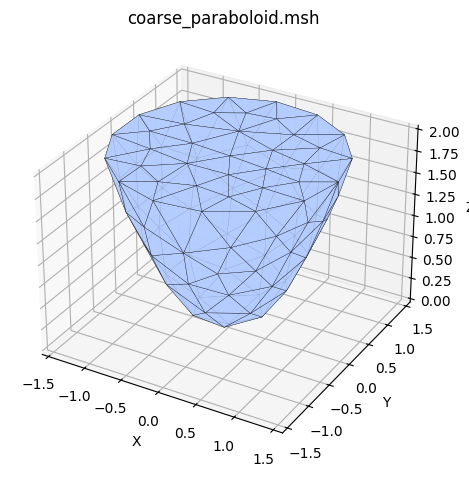

In [713]:
# === Block 2: Display mesh using _plot_mesh.py (uses MESH from Block 1) ===
from pathlib import Path
import importlib.util, sys

PLOT_SCRIPT = (Path.cwd() / "_plot_mesh.py").resolve()
if not PLOT_SCRIPT.exists():
    # fallback if the file lives in /mnt/data
    alt = Path("/mnt/data/_plot_mesh.py")
    if alt.exists():
        PLOT_SCRIPT = alt.resolve()
if not PLOT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _plot_mesh.py in CWD or /mnt/data")

# Dynamically import the plotting helper
spec = importlib.util.spec_from_file_location("plot_mesh_mod", str(PLOT_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules["plot_mesh_mod"] = mod
spec.loader.exec_module(mod)  # type: ignore

# Use MESH from Block 1; fallback to default name if missing
try:
    MESH
except NameError:
    HERE = Path.cwd().resolve()
    MESH = (HERE / "Ellip_0_sub0_full.msh").resolve()

print("Plotting mesh:", MESH)
mod.show_mesh(MESH)


## 4.4 Canonicalize & Transform

In [714]:
from pathlib import Path
import importlib.util, sys, pandas as pd

# Locate transformer script
HERE = Path.cwd().resolve()
CANDIDATES = [
    HERE / "_2_quadric_transformer.py",
    Path("/mnt/data/_2_quadric_transformer.py"),
]
TF_SCRIPT = next((p for p in CANDIDATES if p.exists()), None)
if TF_SCRIPT is None:
    raise FileNotFoundError("Could not find _2_quadric_transformer.py next to the notebook or in /mnt/data")

# Resolve input CSV (use OUT from previous block if available)
try:
    csv_in = Path(OUT).resolve()
except NameError:
    candidates = sorted(HERE.glob("*_COEFFS.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No *_COEFFS.csv found. Run the previous block first or set OUT.")
    csv_in = candidates[0]

print("Transformer script:", TF_SCRIPT)
print("Input CSV         :", csv_in)

# Dynamic import — ensure the module is registered BEFORE exec_module (fixes @dataclass issue)
spec = importlib.util.spec_from_file_location("quadric_tf", str(TF_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = mod  # <-- critical line
spec.loader.exec_module(mod)  # type: ignore

# Transform one file
out_csv, err_csv, n_err = mod.process_file(str(csv_in))
print("Wrote:", out_csv)
if n_err:
    print(f"Errors: {n_err} -> {err_csv}")

# Preview transformed output
df_t = pd.read_csv(out_csv)
print("Transformed rows:", len(df_t), "| Columns:", len(df_t.columns))
display(df_t.head(10))


Transformer script: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_2_quadric_transformer.py
Input CSV         : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS.csv
Wrote: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS_Transformed.csv
Transformed rows: 117 | Columns: 26


triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
0            0     2    51     0                 1                 1   
1            1     0    53     2                 1                 1   
2            2     0    52    20                 1                 1   
3            3    20    53     0                 1                 1   
4            4    51    52     0                 1                 1   
5            5     5    65     1                 1                 1   
6            6     1    66     5                 1                 1   
7            7     1    65     6                 1                 1   
8            8    19    66     1                 1                 1   
9            9     3    24     2                 1                 1   

   scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
0                 1         0.455629         0.000000         0.207596  ...   
1                 1         0.000000         0.000000         0.000000  ...   
2                 1         0.000000         0.000000         0.000000  ...   
3                 1        -0.427680         0.048233         0.185238  ...   
4                 1         0.177750        -0.411273         0.200740  ...   
5                 1         1.233176         0.000000         1.520723  ...   
6                 1         1.414214         0.000000         2.000000  ...   
7                 1         1.414214         0.000000         2.000000  ...   
8                 1         1.291948        -0.575212         2.000000  ...   
9                 1         0.777473         0.000000         0.604464  ...   

   ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
0          1          1          0          0          0          0   
1          1          1          0          0          0          0   
2          1          1          0          0          0          0   
3          1          1          0          0          0          0   
4          1          1          0          0          0          0   
5          1          1          0          0          0          0   
6          1          1          0          0          0          0   
7          1          1          0          0          0          0   
8          1          1          0          0          0          0   
9          1          1          0          0          0          0   

   ABC_new_G  ABC_new_H  ABC_new_I  ABC_new_J  
0          0          0         -1          0  
1          0          0         -1          0  
2          0          0         -1          0  
3          0          0         -1          0  
4          0          0         -1          0  
5          0          0         -1          0  
6          0          0         -1          0  
7          0          0         -1          0  
8          0          0         -1          0  
9          0          0         -1          0  

[10 rows x 26 columns]

## 4.5 Curved Patch Volume (Wedge / Swept-Segment)
## 4.6 Thickness-Weighted Split (A, B, C)
## 4.7 Aggregate Volume & Relative Error
## 4.8 Save Outputs

In [715]:
# === Block: Enforce thickness-weighted split on *_Volume.csv (coarse_hyperboloid) ===
import sys, importlib.util, os, time, tempfile
from pathlib import Path
import pandas as pd
import numpy as np

t0 = time.time()
HERE = Path.cwd().resolve()

# -----------------------------------------------------------------------------------
# 1) Resolve files: use previous block's out_csv if present; otherwise fall back to
#    coarse_hyperboloid_COEFFS_Transformed.csv in the current folder.
# -----------------------------------------------------------------------------------
if 'out_csv' in globals():
    TR_CSV = Path(out_csv).resolve()
else:
    TR_CSV = (HERE / "coarse_hyperboloid_COEFFS_Transformed.csv").resolve()

if not TR_CSV.exists():
    raise FileNotFoundError(f"Transformed CSV not found: {TR_CSV}")

VOL_CSV = TR_CSV.with_name(TR_CSV.stem + "_Volume.csv")

print("[split] Transformed CSV:", TR_CSV)
print("[split] Volume CSV     :", VOL_CSV)

# -----------------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------------
def import_module(script_path: Path, name: str):
    spec = importlib.util.spec_from_file_location(name, str(script_path))
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod  # important for decorators like @dataclass
    spec.loader.exec_module(mod)  # type: ignore
    return mod

def find_script(name: str) -> Path:
    p1 = HERE / name
    p2 = Path("/mnt/data") / name
    if p1.exists(): return p1.resolve()
    if p2.exists(): return p2.resolve()
    raise FileNotFoundError(f"Script not found: {name}")

def pick(df: pd.DataFrame, names):
    for n in names:
        if n in df.columns: return n
    return None

# -----------------------------------------------------------------------------------
# 2) If the Volume CSV for this transformed file doesn't exist yet, generate it now
#    using the same row-by-row routing logic as the volume block.
# -----------------------------------------------------------------------------------
if not VOL_CSV.exists():
    print("Volume CSV missing — generating it now:", VOL_CSV.name)
    df_src = pd.read_csv(TR_CSV)

    Acol = pick(df_src, ["ABC_new_A","ABC_A"]); Bcol = pick(df_src, ["ABC_new_B","ABC_B"]); Ccol = pick(df_src, ["ABC_new_C","ABC_C"])
    Ecol = pick(df_src, ["ABC_new_E","ABC_E"]); Fcol = pick(df_src, ["ABC_new_F","ABC_F"]); Icol = pick(df_src, ["ABC_new_I","ABC_I"])
    Jcol = pick(df_src, ["ABC_new_J","ABC_J"])
    needed = [Acol,Bcol,Ccol,Ecol,Fcol,Icol,Jcol]
    if any(c is None for c in needed):
        miss = [n for c,n in zip(needed,["A","B","C","E","F","I","J"]) if c is None]
        raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

    A = df_src[Acol].to_numpy(); B = df_src[Bcol].to_numpy(); C = df_src[Ccol].to_numpy()
    E = df_src[Ecol].to_numpy(); F = df_src[Fcol].to_numpy(); I = df_src[Icol].to_numpy(); J = df_src[Jcol].to_numpy()

    TOL = 1e-9
    ell_mask = (A > 0) & (B > 0) & (C > 0) & (np.abs(J) > 0)
    noz_mask = (np.abs(C) < TOL) & (np.abs(E) < TOL) & (np.abs(F) < TOL) & (np.abs(I) < TOL)
    axis_mask = ~(ell_mask | noz_mask)

    parts = []
    with tempfile.TemporaryDirectory() as td:
        TMP = Path(td)

        def write_subset(mask, fname):
            if mask.any():
                p = TMP / fname
                df_src.loc[mask].to_csv(p, index=False)
                return p
            return None

        p_ell = write_subset(ell_mask, "ell.csv")
        p_trn = write_subset(noz_mask, "trn.csv")
        p_rot = write_subset(axis_mask, "rot.csv")

        # ellipsoid
        if p_ell is not None:
            m = import_module(find_script("_3_5_volume_ellipsoid.py"), "vol_ell")
            out_csv_ell, _, _, _ = m.process_coeffs_transformed_csv(str(p_ell))
            parts.append(Path(out_csv_ell))

        # translation (writes to CWD)
        if p_trn is not None:
            m = import_module(find_script("All_Translation_Volume_Transformed.py"), "vol_trn")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Translation_Volume_Transformed.py", str(p_trn)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_trn.stem}_Volume.csv")

        # axisymmetric (writes to CWD)
        if p_rot is not None:
            m = import_module(find_script("All_Rotation_Volume_Transformed_v2.py"), "vol_rot")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Rotation_Volume_Transformed_v2.py", str(p_rot)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_rot.stem}_Volume.csv")

        dfs = []
        for p in parts:
            if not p.exists():
                raise FileNotFoundError(f"Expected temp volume file missing: {p}")
            dfs.append(pd.read_csv(p))
        pd.concat(dfs, ignore_index=True).to_csv(VOL_CSV, index=False)

    print("Generated:", VOL_CSV)

# -----------------------------------------------------------------------------------
# 3) Load the final Volume CSV and the transformed CSV (for geometry + coeffs)
# -----------------------------------------------------------------------------------
df_vol = pd.read_csv(VOL_CSV)
df_tr  = pd.read_csv(TR_CSV)

# Ensure triangle_id types align
if "triangle_id" not in df_vol.columns or "triangle_id" not in df_tr.columns:
    raise ValueError("Both CSVs must contain 'triangle_id'.")
df_vol["triangle_id"] = pd.to_numeric(df_vol["triangle_id"], errors="raise").astype(int)
df_tr["triangle_id"]  = pd.to_numeric(df_tr["triangle_id"], errors="raise").astype(int)

# Columns we need from the transformed CSV
coef_cols = {
    "A": pick(df_tr, ["ABC_new_A","ABC_A"]),
    "B": pick(df_tr, ["ABC_new_B","ABC_B"]),
    "C": pick(df_tr, ["ABC_new_C","ABC_C"]),
    "D": pick(df_tr, ["ABC_new_D","ABC_D"]),
    "E": pick(df_tr, ["ABC_new_E","ABC_E"]),
    "F": pick(df_tr, ["ABC_new_F","ABC_F"]),
    "G": pick(df_tr, ["ABC_new_G","ABC_G"]),
    "H": pick(df_tr, ["ABC_new_H","ABC_H"]),
    "I": pick(df_tr, ["ABC_new_I","ABC_I"]),
    "J": pick(df_tr, ["ABC_new_J","ABC_J"]),
}
if any(v is None for v in coef_cols.values()):
    miss = [k for k,v in coef_cols.items() if v is None]
    raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

pt_cols = [
    "A_transformed_x","A_transformed_y","A_transformed_z",
    "B_transformed_x","B_transformed_y","B_transformed_z",
    "C_transformed_x","C_transformed_y","C_transformed_z",
]
if not all(c in df_tr.columns for c in pt_cols):
    raise ValueError(f"Transformed CSV missing required point columns: {set(pt_cols) - set(df_tr.columns)}")

# scaling: prefer 'scaling_factor'; else product(scale_factors1_*); else 1.0
sc_col = pick(df_tr, ["scaling_factor","scale_factor","jacobian","scale"])
if sc_col is None:
    if all(c in df_tr.columns for c in ["scale_factors1_x","scale_factors1_y","scale_factors1_z"]):
        df_tr["__scaling__"] = (
            pd.to_numeric(df_tr["scale_factors1_x"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_y"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_z"], errors="coerce")
        ).fillna(1.0)
        sc_col = "__scaling__"
    else:
        df_tr["__scaling__"] = 1.0
        sc_col = "__scaling__"

# Merge geometry/coeffs onto volume rows via triangle_id
geom_cols = ["triangle_id", sc_col] + pt_cols + list(coef_cols.values())
df = df_vol.merge(df_tr[geom_cols], on="triangle_id", how="left", suffixes=("", "_geom"))

# If some rows lack geometry, just skip recomputing for them (leave as-is)
row_has_geom = ~df[pt_cols].isna().any(axis=1)
miss_cnt = int((~row_has_geom).sum())
if miss_cnt:
    sample = df.loc[~row_has_geom, "triangle_id"].head(8).tolist()
    print(f"⚠️ {miss_cnt} rows in Volume have no matching geometry/coeffs (examples: {sample}). "
          f"They will be left unchanged.")

# -----------------------------------------------------------------------------------
# 4) Load thickness-weighted splitter and recompute patches on matched rows
# -----------------------------------------------------------------------------------
SPLIT_SCRIPT = (HERE / "_4_dualvolume_split_patch_volume_thickness_weighted.py")
if not SPLIT_SCRIPT.exists():
    alt = Path("/mnt/data/_4_dualvolume_split_patch_volume_thickness_weighted.py")
    if alt.exists(): SPLIT_SCRIPT = alt
if not SPLIT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _4_dualvolume_split_patch_volume_thickness_weighted.py")

split_mod = import_module(SPLIT_SCRIPT, "split_mod")
split_fn = getattr(split_mod, "split_patch_volume_thickness_weighted", None)
if split_fn is None:
    raise AttributeError("split_patch_volume_thickness_weighted not found in splitter module.")

vA_list, vB_list, vC_list = [], [], []
vAs_list, vBs_list, vCs_list = [], [], []
tri_list = []
repaired = 0

df_work = df.loc[row_has_geom].copy()
for _, row in df_work.iterrows():
    V = float(row.get("Vcorrection", 0.0))
    Axyz = np.array([row["A_transformed_x"], row["A_transformed_y"], row["A_transformed_z"]], float)
    Bxyz = np.array([row["B_transformed_x"], row["B_transformed_y"], row["B_transformed_z"]], float)
    Cxyz = np.array([row["C_transformed_x"], row["C_transformed_y"], row["C_transformed_z"]], float)
    coeffs = tuple(float(row[coef_cols[k]]) for k in ["A","B","C","D","E","F","G","H","I","J"])
    s = float(row[sc_col]) if np.isfinite(row[sc_col]) else 1.0
    if not np.isfinite(s) or abs(s) < 1e-30:
        s = 1.0  # guard against bad/zero scaling

    try:
        vA, vB, vC = split_fn(V, Axyz, Bxyz, Cxyz, coeffs, eps=1e-12)
        S = vA + vB + vC
        if not np.isfinite(S) or abs(S) < 1e-30:
            raise ValueError("ill-conditioned sum")
        scale = V / S if S != 0 else 0.0
        vA *= scale; vB *= scale; vC = V - vA - vB
    except Exception:
        repaired += 1
        vA = vB = vC = V / 3.0

    tri_list.append(int(row["triangle_id"]))
    # ---------------------- IMPORTANT CHANGE ----------------------
    # To enforce: Vcorrection_scal * scaling_factor = Vcorrection
    # -> *_scal must be the unscaled (unit-space) values: divide by s
    vA_list.append(vA); vB_list.append(vB); vC_list.append(vC)
    vAs_list.append(vA / s); vBs_list.append(vB / s); vCs_list.append(vC / s)
    # --------------------------------------------------------------

# Write recomputed values back (matched rows only)
if tri_list:
    df_vol = df_vol.set_index("triangle_id")
    df_tmp = pd.DataFrame({
        "triangle_id": tri_list,
        "V_patch_A": vA_list, "V_patch_B": vB_list, "V_patch_C": vC_list,
        "V_patch_A_scal": vAs_list, "V_patch_B_scal": vBs_list, "V_patch_C_scal": vCs_list,
    }).set_index("triangle_id")
    df_vol.update(df_tmp)
    df_vol = df_vol.reset_index()

# Always recompute sums from current patches
if {"V_patch_A","V_patch_B","V_patch_C"}.issubset(df_vol.columns):
    df_vol["Vcorrection"] = df_vol[["V_patch_A","V_patch_B","V_patch_C"]].sum(axis=1)
if {"V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"}.issubset(df_vol.columns):
    df_vol["Vcorrection_scal"] = df_vol[["V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"]].sum(axis=1)

# Save
df_vol.to_csv(VOL_CSV, index=False)

# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format) + equality check
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")

# Quick consistency check for the desired relation
if "Vcorrection_scal" in df_vol.columns:
    # If the scaling column exists in df_tr, merge it for checking
    try:
        chk = df_vol.merge(df_tr[["triangle_id", sc_col]], on="triangle_id", how="left")
        lhs = chk["Vcorrection_scal"] * chk[sc_col]
        rhs = chk["Vcorrection"]
        diff = (lhs - rhs).to_numpy()
        mask = np.isfinite(diff)
        if mask.any():
            print("Check: max|Vcorrection_scal*scaling_factor - Vcorrection| =", float(np.max(np.abs(diff[mask]))))
    except Exception as _e:
        print("Check skipped (unable to merge scaling column).")


# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format)
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")
print("**************************************************")
print("relative error", (  6.00336629  + V_sum -  6.28318531 )/ 6.28318531*100,"%")
print("**************************************************")
print(f"Total elapsed: {t1 - t0:.2f} s")
print(f"[write] {os.path.abspath(VOL_CSV)}")

try:
    display(df_vol.head(10))
except Exception:
    print(df_vol.head(10).to_string(index=False))


[split] Transformed CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS_Transformed.csv
[split] Volume CSV     : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS_Transformed_Volume.csv
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS_Transformed.csv
Triangles written: 117 | (degenerate≈zero) flagged: 0 | recomputed rows=117 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.28162543
Check: max|Vcorrection_scal*scaling_factor - Vcorrection| = 0.0
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/coarse_paraboloid_COEFFS_Transformed.csv
Triangles written: 117 | (degenerate≈zero) flagged: 0 | recomputed rows=117 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.28162543
**************************************************
relative error 0.028749974515061606 %
********

triangle_id  Vcorrection  V_patch_A  V_patch_B  V_patch_C  scaling_factor  \
0            0     0.005741   0.001914   0.001914   0.001914             1.0   
1            1     0.005940   0.001980   0.001980   0.001980             1.0   
2            2     0.005853   0.001951   0.001951   0.001951             1.0   
3            3     0.011844   0.003948   0.003948   0.003948             1.0   
4            4     0.004706   0.001569   0.001569   0.001569             1.0   
5            5     0.000932   0.000311   0.000311   0.000311             1.0   
6            6     0.000984   0.000328   0.000328   0.000328             1.0   
7            7     0.001681   0.000560   0.000560   0.000560             1.0   
8            8     0.001626   0.000542   0.000542   0.000542             1.0   
9            9     0.003085   0.001028   0.001028   0.001028             1.0   

   Vcorrection_scal  V_patch_A_scal  V_patch_B_scal  V_patch_C_scal     side  
0          0.005741        0.001914        0.001914        0.001914  outward  
1          0.005940        0.001980        0.001980        0.001980  outward  
2          0.005853        0.001951        0.001951        0.001951  outward  
3          0.011844        0.003948        0.003948        0.003948  outward  
4          0.004706        0.001569        0.001569        0.001569  outward  
5          0.000932        0.000311        0.000311        0.000311  outward  
6          0.000984        0.000328        0.000328        0.000328  outward  
7          0.001681        0.000560        0.000560        0.000560  outward  
8          0.001626        0.000542        0.000542        0.000542  outward  
9          0.003085        0.001028        0.001028        0.001028  outward

## 5. Hyperbolic Cylinder
## 5.1 Load Hyperbolic Cylinder Mesh
## 5.2 Fit Local Quadrics (ABC Coefficients)

In [716]:
import subprocess, sys, shlex
from pathlib import Path

HERE   = Path.cwd().resolve()                    # folder containing the notebook, .msh, and script
SCRIPT = (HERE / "_1_coeffs_computing.py").resolve()
MESH   = (HERE / "hyperbola_cylinder_x2_minus_y2_z1slice.msh").resolve()    # <-- change filename if needed
OUT    = (HERE / f"{MESH.stem}_COEFFS.csv").resolve()

print("Script :", SCRIPT)
print("Mesh   :", MESH)
print("Output :", OUT)

if not MESH.exists():
    raise FileNotFoundError(f"Input .msh not found at: {MESH}")

cmd = [sys.executable, str(SCRIPT), "--msh", str(MESH), "--out", str(OUT)]
print("Running:", " ".join(shlex.quote(c) for c in cmd))

res = subprocess.run(cmd, check=True, capture_output=True, text=True)
if res.stdout: print(res.stdout)
if res.stderr: print(res.stderr)
print(f"✅ Done! Output written to {OUT}")


Script : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py
Mesh   : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice.msh
Output : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS.csv
Running: '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/venv/bin/python' '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py' --msh '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice.msh' --out '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS.csv'

[triangles] explicit surface faces: 349 (from 11 block(s))
[mesh] points=176  surface_triangles=349
[smooth] components: 7 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx

## 5.3 Display Hyperbolic Cylinder Mesh


Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice.msh

[loaded] hyperbola_cylinder_x2_minus_y2_z1slice.msh
  points: 176
  cells[triangle]: 12
  cells[triangle]: 55
  cells[triangle]: 32
  cells[triangle]: 55
  cells[triangle]: 36
  cells[triangle]: 12
  cells[triangle]: 12
  cells[triangle]: 32
  cells[triangle]: 55
  cells[triangle]: 36
  cells[triangle]: 12
  cells[tetra]: 268
  cells[tetra]: 268
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


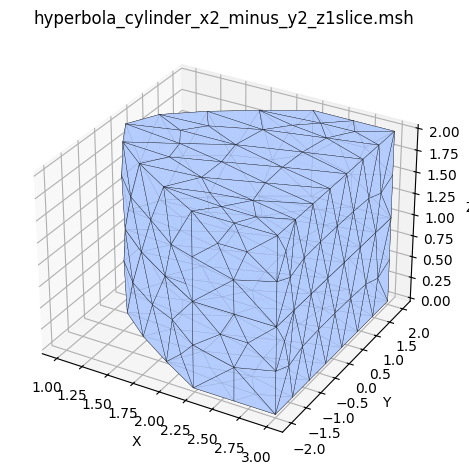

In [717]:
# === Block 2: Display mesh using _plot_mesh.py (uses MESH from Block 1) ===
from pathlib import Path
import importlib.util, sys

PLOT_SCRIPT = (Path.cwd() / "_plot_mesh.py").resolve()
if not PLOT_SCRIPT.exists():
    # fallback if the file lives in /mnt/data
    alt = Path("/mnt/data/_plot_mesh.py")
    if alt.exists():
        PLOT_SCRIPT = alt.resolve()
if not PLOT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _plot_mesh.py in CWD or /mnt/data")

# Dynamically import the plotting helper
spec = importlib.util.spec_from_file_location("plot_mesh_mod", str(PLOT_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules["plot_mesh_mod"] = mod
spec.loader.exec_module(mod)  # type: ignore

# Use MESH from Block 1; fallback to default name if missing
try:
    MESH
except NameError:
    HERE = Path.cwd().resolve()
    MESH = (HERE / "Ellip_0_sub0_full.msh").resolve()

print("Plotting mesh:", MESH)
mod.show_mesh(MESH)


## 5.4 Canonicalize & Transform 


In [718]:
from pathlib import Path
import importlib.util, sys, pandas as pd

# Locate transformer script
HERE = Path.cwd().resolve()
CANDIDATES = [
    HERE / "_2_quadric_transformer.py",
    Path("/mnt/data/_2_quadric_transformer.py"),
]
TF_SCRIPT = next((p for p in CANDIDATES if p.exists()), None)
if TF_SCRIPT is None:
    raise FileNotFoundError("Could not find _2_quadric_transformer.py next to the notebook or in /mnt/data")

# Resolve input CSV (use OUT from previous block if available)
try:
    csv_in = Path(OUT).resolve()
except NameError:
    candidates = sorted(HERE.glob("*_COEFFS.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No *_COEFFS.csv found. Run the previous block first or set OUT.")
    csv_in = candidates[0]

print("Transformer script:", TF_SCRIPT)
print("Input CSV         :", csv_in)

# Dynamic import — ensure the module is registered BEFORE exec_module (fixes @dataclass issue)
spec = importlib.util.spec_from_file_location("quadric_tf", str(TF_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = mod  # <-- critical line
spec.loader.exec_module(mod)  # type: ignore

# Transform one file
out_csv, err_csv, n_err = mod.process_file(str(csv_in))
print("Wrote:", out_csv)
if n_err:
    print(f"Errors: {n_err} -> {err_csv}")

# Preview transformed output
df_t = pd.read_csv(out_csv)
print("Transformed rows:", len(df_t), "| Columns:", len(df_t.columns))
display(df_t.head(10))


Transformer script: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_2_quadric_transformer.py
Input CSV         : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS.csv
Wrote: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS_Transformed.csv
Transformed rows: 72 | Columns: 26


triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
0          154     0   120    15          0.999992          1.000001   
1          155    29   120     0          0.999989          1.000001   
2          156    15   120     3          1.000060          0.999987   
3          157     3   120    38          1.000000          1.000000   
4          158     5   122    23          0.999990          1.000001   
5          159    45   122     5          0.999990          1.000001   
6          160    44   121     7          1.000000          1.000000   
7          161     7   121    45          1.000051          0.999989   
8          162    23   119    24          1.000000          1.000000   
9          163    23   121   119          1.000000          1.000000   

   scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
0                 1         2.236086         1.999998              0.0  ...   
1                 1         1.843189         1.548309              0.0  ...   
2                 1         2.235933         2.000026              0.5  ...   
3                 1         2.236068         2.000000              1.0  ...   
4                 1         2.236091        -1.999997              0.0  ...   
5                 1         2.236091        -1.999997              0.5  ...   
6                 1         1.843168        -1.548311              1.0  ...   
7                 1         2.235955        -2.000022              1.0  ...   
8                 1         1.843168        -1.548311              0.0  ...   
9                 1         1.843168        -1.548311              0.0  ...   

   ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
0          1         -1          0   0.000000          0          0   
1          1         -1          0   0.000000          0          0   
2          1         -1          0   0.000143          0          0   
3          1         -1          0   0.000000          0          0   
4          1         -1          0   0.000000          0          0   
5          1         -1          0   0.000000          0          0   
6          1         -1          0   0.000000          0          0   
7          1         -1          0  -0.000121          0          0   
8          1         -1          0   0.000000          0          0   
9          1         -1          0   0.000000          0          0   

   ABC_new_G  ABC_new_H  ABC_new_I  ABC_new_J  
0   0.000000   0.000000          0         -1  
1   0.000000   0.000000          0         -1  
2   0.000107  -0.000086          0         -1  
3   0.000000   0.000000          0         -1  
4   0.000000   0.000000          0         -1  
5   0.000000   0.000000          0         -1  
6   0.000000   0.000000          0         -1  
7   0.000089   0.000073          0         -1  
8   0.000000   0.000000          0         -1  
9   0.000000   0.000000          0         -1  

[10 rows x 26 columns]

## 5.5 Curved Patch Volume (Wedge / Swept-Segment)
## 5.6 Thickness-Weighted Split (A, B, C)
## 5.7 Aggregate Volume & Relative Error
## 5.8 Visualization & Diagnostics
## 5.9 Save Outputs

In [719]:
# === Block: Enforce thickness-weighted split on *_Volume.csv (coarse_hyperboloid) ===
import sys, importlib.util, os, time, tempfile
from pathlib import Path
import pandas as pd
import numpy as np

t0 = time.time()
HERE = Path.cwd().resolve()

# -----------------------------------------------------------------------------------
# 1) Resolve files: use previous block's out_csv if present; otherwise fall back to
#    coarse_hyperboloid_COEFFS_Transformed.csv in the current folder.
# -----------------------------------------------------------------------------------
if 'out_csv' in globals():
    TR_CSV = Path(out_csv).resolve()
else:
    TR_CSV = (HERE / "coarse_hyperboloid_COEFFS_Transformed.csv").resolve()

if not TR_CSV.exists():
    raise FileNotFoundError(f"Transformed CSV not found: {TR_CSV}")

VOL_CSV = TR_CSV.with_name(TR_CSV.stem + "_Volume.csv")

print("[split] Transformed CSV:", TR_CSV)
print("[split] Volume CSV     :", VOL_CSV)

# -----------------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------------
def import_module(script_path: Path, name: str):
    spec = importlib.util.spec_from_file_location(name, str(script_path))
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod  # important for decorators like @dataclass
    spec.loader.exec_module(mod)  # type: ignore
    return mod

def find_script(name: str) -> Path:
    p1 = HERE / name
    p2 = Path("/mnt/data") / name
    if p1.exists(): return p1.resolve()
    if p2.exists(): return p2.resolve()
    raise FileNotFoundError(f"Script not found: {name}")

def pick(df: pd.DataFrame, names):
    for n in names:
        if n in df.columns: return n
    return None

# -----------------------------------------------------------------------------------
# 2) If the Volume CSV for this transformed file doesn't exist yet, generate it now
#    using the same row-by-row routing logic as the volume block.
# -----------------------------------------------------------------------------------
if not VOL_CSV.exists():
    print("Volume CSV missing — generating it now:", VOL_CSV.name)
    df_src = pd.read_csv(TR_CSV)

    Acol = pick(df_src, ["ABC_new_A","ABC_A"]); Bcol = pick(df_src, ["ABC_new_B","ABC_B"]); Ccol = pick(df_src, ["ABC_new_C","ABC_C"])
    Ecol = pick(df_src, ["ABC_new_E","ABC_E"]); Fcol = pick(df_src, ["ABC_new_F","ABC_F"]); Icol = pick(df_src, ["ABC_new_I","ABC_I"])
    Jcol = pick(df_src, ["ABC_new_J","ABC_J"])
    needed = [Acol,Bcol,Ccol,Ecol,Fcol,Icol,Jcol]
    if any(c is None for c in needed):
        miss = [n for c,n in zip(needed,["A","B","C","E","F","I","J"]) if c is None]
        raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

    A = df_src[Acol].to_numpy(); B = df_src[Bcol].to_numpy(); C = df_src[Ccol].to_numpy()
    E = df_src[Ecol].to_numpy(); F = df_src[Fcol].to_numpy(); I = df_src[Icol].to_numpy(); J = df_src[Jcol].to_numpy()

    TOL = 1e-9
    ell_mask = (A > 0) & (B > 0) & (C > 0) & (np.abs(J) > 0)
    noz_mask = (np.abs(C) < TOL) & (np.abs(E) < TOL) & (np.abs(F) < TOL) & (np.abs(I) < TOL)
    axis_mask = ~(ell_mask | noz_mask)

    parts = []
    with tempfile.TemporaryDirectory() as td:
        TMP = Path(td)

        def write_subset(mask, fname):
            if mask.any():
                p = TMP / fname
                df_src.loc[mask].to_csv(p, index=False)
                return p
            return None

        p_ell = write_subset(ell_mask, "ell.csv")
        p_trn = write_subset(noz_mask, "trn.csv")
        p_rot = write_subset(axis_mask, "rot.csv")

        # ellipsoid
        if p_ell is not None:
            m = import_module(find_script("_3_5_volume_ellipsoid.py"), "vol_ell")
            out_csv_ell, _, _, _ = m.process_coeffs_transformed_csv(str(p_ell))
            parts.append(Path(out_csv_ell))

        # translation (writes to CWD)
        if p_trn is not None:
            m = import_module(find_script("All_Translation_Volume_Transformed.py"), "vol_trn")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Translation_Volume_Transformed.py", str(p_trn)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_trn.stem}_Volume.csv")

        # axisymmetric (writes to CWD)
        if p_rot is not None:
            m = import_module(find_script("All_Rotation_Volume_Transformed_v2.py"), "vol_rot")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Rotation_Volume_Transformed_v2.py", str(p_rot)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_rot.stem}_Volume.csv")

        dfs = []
        for p in parts:
            if not p.exists():
                raise FileNotFoundError(f"Expected temp volume file missing: {p}")
            dfs.append(pd.read_csv(p))
        pd.concat(dfs, ignore_index=True).to_csv(VOL_CSV, index=False)

    print("Generated:", VOL_CSV)

# -----------------------------------------------------------------------------------
# 3) Load the final Volume CSV and the transformed CSV (for geometry + coeffs)
# -----------------------------------------------------------------------------------
df_vol = pd.read_csv(VOL_CSV)
df_tr  = pd.read_csv(TR_CSV)

# Ensure triangle_id types align
if "triangle_id" not in df_vol.columns or "triangle_id" not in df_tr.columns:
    raise ValueError("Both CSVs must contain 'triangle_id'.")
df_vol["triangle_id"] = pd.to_numeric(df_vol["triangle_id"], errors="raise").astype(int)
df_tr["triangle_id"]  = pd.to_numeric(df_tr["triangle_id"], errors="raise").astype(int)

# Columns we need from the transformed CSV
coef_cols = {
    "A": pick(df_tr, ["ABC_new_A","ABC_A"]),
    "B": pick(df_tr, ["ABC_new_B","ABC_B"]),
    "C": pick(df_tr, ["ABC_new_C","ABC_C"]),
    "D": pick(df_tr, ["ABC_new_D","ABC_D"]),
    "E": pick(df_tr, ["ABC_new_E","ABC_E"]),
    "F": pick(df_tr, ["ABC_new_F","ABC_F"]),
    "G": pick(df_tr, ["ABC_new_G","ABC_G"]),
    "H": pick(df_tr, ["ABC_new_H","ABC_H"]),
    "I": pick(df_tr, ["ABC_new_I","ABC_I"]),
    "J": pick(df_tr, ["ABC_new_J","ABC_J"]),
}
if any(v is None for v in coef_cols.values()):
    miss = [k for k,v in coef_cols.items() if v is None]
    raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

pt_cols = [
    "A_transformed_x","A_transformed_y","A_transformed_z",
    "B_transformed_x","B_transformed_y","B_transformed_z",
    "C_transformed_x","C_transformed_y","C_transformed_z",
]
if not all(c in df_tr.columns for c in pt_cols):
    raise ValueError(f"Transformed CSV missing required point columns: {set(pt_cols) - set(df_tr.columns)}")

# scaling: prefer 'scaling_factor'; else product(scale_factors1_*); else 1.0
sc_col = pick(df_tr, ["scaling_factor","scale_factor","jacobian","scale"])
if sc_col is None:
    if all(c in df_tr.columns for c in ["scale_factors1_x","scale_factors1_y","scale_factors1_z"]):
        df_tr["__scaling__"] = (
            pd.to_numeric(df_tr["scale_factors1_x"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_y"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_z"], errors="coerce")
        ).fillna(1.0)
        sc_col = "__scaling__"
    else:
        df_tr["__scaling__"] = 1.0
        sc_col = "__scaling__"

# Merge geometry/coeffs onto volume rows via triangle_id
geom_cols = ["triangle_id", sc_col] + pt_cols + list(coef_cols.values())
df = df_vol.merge(df_tr[geom_cols], on="triangle_id", how="left", suffixes=("", "_geom"))

# If some rows lack geometry, just skip recomputing for them (leave as-is)
row_has_geom = ~df[pt_cols].isna().any(axis=1)
miss_cnt = int((~row_has_geom).sum())
if miss_cnt:
    sample = df.loc[~row_has_geom, "triangle_id"].head(8).tolist()
    print(f"⚠️ {miss_cnt} rows in Volume have no matching geometry/coeffs (examples: {sample}). "
          f"They will be left unchanged.")

# -----------------------------------------------------------------------------------
# 4) Load thickness-weighted splitter and recompute patches on matched rows
# -----------------------------------------------------------------------------------
SPLIT_SCRIPT = (HERE / "_4_dualvolume_split_patch_volume_thickness_weighted.py")
if not SPLIT_SCRIPT.exists():
    alt = Path("/mnt/data/_4_dualvolume_split_patch_volume_thickness_weighted.py")
    if alt.exists(): SPLIT_SCRIPT = alt
if not SPLIT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _4_dualvolume_split_patch_volume_thickness_weighted.py")

split_mod = import_module(SPLIT_SCRIPT, "split_mod")
split_fn = getattr(split_mod, "split_patch_volume_thickness_weighted", None)
if split_fn is None:
    raise AttributeError("split_patch_volume_thickness_weighted not found in splitter module.")

vA_list, vB_list, vC_list = [], [], []
vAs_list, vBs_list, vCs_list = [], [], []
tri_list = []
repaired = 0

df_work = df.loc[row_has_geom].copy()
for _, row in df_work.iterrows():
    V = float(row.get("Vcorrection", 0.0))
    Axyz = np.array([row["A_transformed_x"], row["A_transformed_y"], row["A_transformed_z"]], float)
    Bxyz = np.array([row["B_transformed_x"], row["B_transformed_y"], row["B_transformed_z"]], float)
    Cxyz = np.array([row["C_transformed_x"], row["C_transformed_y"], row["C_transformed_z"]], float)
    coeffs = tuple(float(row[coef_cols[k]]) for k in ["A","B","C","D","E","F","G","H","I","J"])
    s = float(row[sc_col]) if np.isfinite(row[sc_col]) else 1.0
    if not np.isfinite(s) or abs(s) < 1e-30:
        s = 1.0  # guard against bad/zero scaling

    try:
        vA, vB, vC = split_fn(V, Axyz, Bxyz, Cxyz, coeffs, eps=1e-12)
        S = vA + vB + vC
        if not np.isfinite(S) or abs(S) < 1e-30:
            raise ValueError("ill-conditioned sum")
        scale = V / S if S != 0 else 0.0
        vA *= scale; vB *= scale; vC = V - vA - vB
    except Exception:
        repaired += 1
        vA = vB = vC = V / 3.0

    tri_list.append(int(row["triangle_id"]))
    # ---------------------- IMPORTANT CHANGE ----------------------
    # To enforce: Vcorrection_scal * scaling_factor = Vcorrection
    # -> *_scal must be the unscaled (unit-space) values: divide by s
    vA_list.append(vA); vB_list.append(vB); vC_list.append(vC)
    vAs_list.append(vA / s); vBs_list.append(vB / s); vCs_list.append(vC / s)
    # --------------------------------------------------------------

# Write recomputed values back (matched rows only)
if tri_list:
    df_vol = df_vol.set_index("triangle_id")
    df_tmp = pd.DataFrame({
        "triangle_id": tri_list,
        "V_patch_A": vA_list, "V_patch_B": vB_list, "V_patch_C": vC_list,
        "V_patch_A_scal": vAs_list, "V_patch_B_scal": vBs_list, "V_patch_C_scal": vCs_list,
    }).set_index("triangle_id")
    df_vol.update(df_tmp)
    df_vol = df_vol.reset_index()

# Always recompute sums from current patches
if {"V_patch_A","V_patch_B","V_patch_C"}.issubset(df_vol.columns):
    df_vol["Vcorrection"] = df_vol[["V_patch_A","V_patch_B","V_patch_C"]].sum(axis=1)
if {"V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"}.issubset(df_vol.columns):
    df_vol["Vcorrection_scal"] = df_vol[["V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"]].sum(axis=1)

# Save
df_vol.to_csv(VOL_CSV, index=False)

# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format) + equality check
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")

# Quick consistency check for the desired relation
if "Vcorrection_scal" in df_vol.columns:
    # If the scaling column exists in df_tr, merge it for checking
    try:
        chk = df_vol.merge(df_tr[["triangle_id", sc_col]], on="triangle_id", how="left")
        lhs = chk["Vcorrection_scal"] * chk[sc_col]
        rhs = chk["Vcorrection"]
        diff = (lhs - rhs).to_numpy()
        mask = np.isfinite(diff)
        if mask.any():
            print("Check: max|Vcorrection_scal*scaling_factor - Vcorrection| =", float(np.max(np.abs(diff[mask]))))
    except Exception as _e:
        print("Check skipped (unable to merge scaling column).")


# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format)
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")
print("**************************************************")
print("relative error", (  12.10482688  + V_sum -  12.16845714 )/ 12.16845714*100,"%")
print("**************************************************")
print(f"Total elapsed: {t1 - t0:.2f} s")
print(f"[write] {os.path.abspath(VOL_CSV)}")

try:
    display(df_vol.head(10))
except Exception:
    print(df_vol.head(10).to_string(index=False))


[split] Transformed CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS_Transformed.csv
[split] Volume CSV     : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS_Transformed_Volume.csv
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS_Transformed.csv
Triangles written: 72 | (degenerate≈zero) flagged: 0 | recomputed rows=72 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.06359680
Check: max|Vcorrection_scal*scaling_factor - Vcorrection| = 2.710505431213761e-20
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS_Transformed.csv
Triangles written: 72 | (degenerate≈zero) flagged: 0 | recomputed rows=72 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.06359680

triangle_id  Vcorrection  V_patch_A  V_patch_B  V_patch_C  scaling_factor  \
0          154     0.000084   0.000024   0.000036   0.000024        0.999993   
1          155     0.000211   0.000071   0.000052   0.000088        0.999990   
2          156     0.000088   0.000025   0.000037   0.000025        1.000047   
3          157     0.000158   0.000066   0.000039   0.000053        1.000000   
4          158     0.000089   0.000032   0.000021   0.000036        0.999991   
5          159     0.000022   0.000006   0.000009   0.000006        0.999991   
6          160     0.000158   0.000053   0.000039   0.000066        1.000000   
7          161     0.000088   0.000025   0.000037   0.000025        1.000040   
8          162     0.000371   0.000142   0.000087   0.000143        1.000000   
9          163     0.000157   0.000038   0.000053   0.000066        1.000000   

   Vcorrection_scal  V_patch_A_scal  V_patch_B_scal  V_patch_C_scal     side  
0          0.000084        0.000024        0.000036        0.000024  outside  
1          0.000211        0.000071        0.000052        0.000088  outside  
2          0.000088        0.000025        0.000037        0.000025  outside  
3          0.000158        0.000066        0.000039        0.000053  outside  
4          0.000089        0.000032        0.000021        0.000036  outside  
5          0.000022        0.000006        0.000009        0.000006  outside  
6          0.000158        0.000053        0.000039        0.000066  outside  
7          0.000088        0.000025        0.000037        0.000025  outside  
8          0.000371        0.000142        0.000087        0.000143  outside  
9          0.000157        0.000038        0.000053        0.000066  outside

## 6. Circular Cylinder
## 6.1 Load Cylinder Mesh
## 6.2 Fit Local Quadrics (ABC Coefficients)


In [720]:
import subprocess, sys, shlex
from pathlib import Path

HERE   = Path.cwd().resolve()                    # folder containing the notebook, .msh, and script
SCRIPT = (HERE / "_1_coeffs_computing.py").resolve()
MESH   = (HERE / "cylinder.msh").resolve()    # <-- change filename if needed
OUT    = (HERE / f"{MESH.stem}_COEFFS.csv").resolve()

print("Script :", SCRIPT)
print("Mesh   :", MESH)
print("Output :", OUT)

if not MESH.exists():
    raise FileNotFoundError(f"Input .msh not found at: {MESH}")

cmd = [sys.executable, str(SCRIPT), "--msh", str(MESH), "--out", str(OUT)]
print("Running:", " ".join(shlex.quote(c) for c in cmd))

res = subprocess.run(cmd, check=True, capture_output=True, text=True)
if res.stdout: print(res.stdout)
if res.stderr: print(res.stderr)
print(f"✅ Done! Output written to {OUT}")


Script : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py
Mesh   : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder.msh
Output : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS.csv
Running: '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/venv/bin/python' '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_1_coeffs_computing.py' --msh '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder.msh' --out '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS.csv'

[triangles] explicit surface faces: 374 (from 1 block(s))
[mesh] points=229  surface_triangles=374
[smooth] components: 3 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS.csv  (rows kept=180, skipped_flat=194, total_tris=374)
[ok] N

## 6.3 Display Circular Cylinder Mesh


Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder.msh

[loaded] cylinder.msh
  points: 229
  cells[vertex]: 2
  cells[line]: 46
  cells[triangle]: 374
  cells[tetra]: 736
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


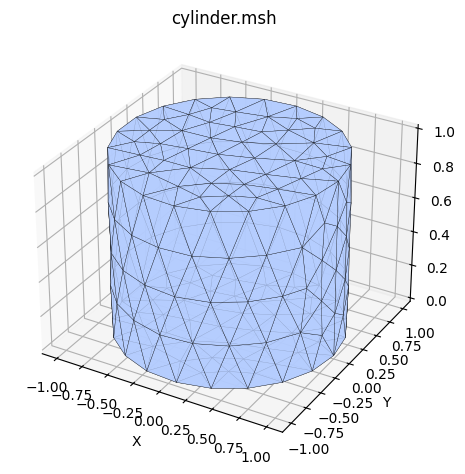

In [721]:
# === Block 2: Display mesh using _plot_mesh.py (uses MESH from Block 1) ===
from pathlib import Path
import importlib.util, sys

PLOT_SCRIPT = (Path.cwd() / "_plot_mesh.py").resolve()
if not PLOT_SCRIPT.exists():
    # fallback if the file lives in /mnt/data
    alt = Path("/mnt/data/_plot_mesh.py")
    if alt.exists():
        PLOT_SCRIPT = alt.resolve()
if not PLOT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _plot_mesh.py in CWD or /mnt/data")

# Dynamically import the plotting helper
spec = importlib.util.spec_from_file_location("plot_mesh_mod", str(PLOT_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules["plot_mesh_mod"] = mod
spec.loader.exec_module(mod)  # type: ignore

# Use MESH from Block 1; fallback to default name if missing
try:
    MESH
except NameError:
    HERE = Path.cwd().resolve()
    MESH = (HERE / "Ellip_0_sub0_full.msh").resolve()

print("Plotting mesh:", MESH)
mod.show_mesh(MESH)


## 6.4 Canonicalize & Transform  


In [722]:
from pathlib import Path
import importlib.util, sys, pandas as pd

# Locate transformer script
HERE = Path.cwd().resolve()
CANDIDATES = [
    HERE / "_2_quadric_transformer.py",
    Path("/mnt/data/_2_quadric_transformer.py"),
]
TF_SCRIPT = next((p for p in CANDIDATES if p.exists()), None)
if TF_SCRIPT is None:
    raise FileNotFoundError("Could not find _2_quadric_transformer.py next to the notebook or in /mnt/data")

# Resolve input CSV (use OUT from previous block if available)
try:
    csv_in = Path(OUT).resolve()
except NameError:
    candidates = sorted(HERE.glob("*_COEFFS.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No *_COEFFS.csv found. Run the previous block first or set OUT.")
    csv_in = candidates[0]

print("Transformer script:", TF_SCRIPT)
print("Input CSV         :", csv_in)

# Dynamic import — ensure the module is registered BEFORE exec_module (fixes @dataclass issue)
spec = importlib.util.spec_from_file_location("quadric_tf", str(TF_SCRIPT))
mod = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = mod  # <-- critical line
spec.loader.exec_module(mod)  # type: ignore

# Transform one file
out_csv, err_csv, n_err = mod.process_file(str(csv_in))
print("Wrote:", out_csv)
if n_err:
    print(f"Errors: {n_err} -> {err_csv}")

# Preview transformed output
df_t = pd.read_csv(out_csv)
print("Transformed rows:", len(df_t), "| Columns:", len(df_t.columns))
display(df_t.head(10))


Transformer script: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/_2_quadric_transformer.py
Input CSV         : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS.csv
Wrote: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS_Transformed.csv
Transformed rows: 180 | Columns: 26


triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
0            0     0   106     2                 1                 1   
1            1    21   110     0                 1                 1   
2            2    24   106     0                 1                 1   
3            3     0   110    24                 1                 1   
4            4     1   108    22                 1                 1   
5            5    22   109     1                 1                 1   
6            6    25   108     1                 1                 1   
7            7     1   109    44                 1                 1   
8            8     2    53     3                 1                 1   
9            9     2   106    53                 1                 1   

   scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
0                 1         1.000000    -2.449294e-16             1.00  ...   
1                 1         0.955573    -2.947552e-01             1.00  ...   
2                 1         1.000000    -2.449294e-16             0.75  ...   
3                 1         1.000000    -2.449294e-16             1.00  ...   
4                 1         1.000000    -2.449294e-16             0.00  ...   
5                 1         1.000000    -2.449294e-16             0.25  ...   
6                 1         0.955573     2.947552e-01             0.00  ...   
7                 1         1.000000    -2.449294e-16             0.00  ...   
8                 1         0.955573     2.947552e-01             1.00  ...   
9                 1         0.955573     2.947552e-01             1.00  ...   

   ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
0          1          1          0          0          0          0   
1          1          1          0          0          0          0   
2          1          1          0          0          0          0   
3          1          1          0          0          0          0   
4          1          1          0          0          0          0   
5          1          1          0          0          0          0   
6          1          1          0          0          0          0   
7          1          1          0          0          0          0   
8          1          1          0          0          0          0   
9          1          1          0          0          0          0   

   ABC_new_G  ABC_new_H  ABC_new_I  ABC_new_J  
0          0          0          0         -1  
1          0          0          0         -1  
2          0          0          0         -1  
3          0          0          0         -1  
4          0          0          0         -1  
5          0          0          0         -1  
6          0          0          0         -1  
7          0          0          0         -1  
8          0          0          0         -1  
9          0          0          0         -1  

[10 rows x 26 columns]

## 6.5 Curved Patch Volume (Wedge / Swept-Segment)
## 6.6 Thickness-Weighted Split (A, B, C)
## 6.7 Aggregate Volume & Relative Error
## 6.8 Visualization & Diagnostics
## 6.9 Save Outputs

In [723]:
# === Block: Enforce thickness-weighted split on *_Volume.csv (coarse_hyperboloid) ===
import sys, importlib.util, os, time, tempfile
from pathlib import Path
import pandas as pd
import numpy as np

t0 = time.time()
HERE = Path.cwd().resolve()

# -----------------------------------------------------------------------------------
# 1) Resolve files: use previous block's out_csv if present; otherwise fall back to
#    coarse_hyperboloid_COEFFS_Transformed.csv in the current folder.
# -----------------------------------------------------------------------------------
if 'out_csv' in globals():
    TR_CSV = Path(out_csv).resolve()
else:
    TR_CSV = (HERE / "coarse_hyperboloid_COEFFS_Transformed.csv").resolve()

if not TR_CSV.exists():
    raise FileNotFoundError(f"Transformed CSV not found: {TR_CSV}")

VOL_CSV = TR_CSV.with_name(TR_CSV.stem + "_Volume.csv")

print("[split] Transformed CSV:", TR_CSV)
print("[split] Volume CSV     :", VOL_CSV)

# -----------------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------------
def import_module(script_path: Path, name: str):
    spec = importlib.util.spec_from_file_location(name, str(script_path))
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod  # important for decorators like @dataclass
    spec.loader.exec_module(mod)  # type: ignore
    return mod

def find_script(name: str) -> Path:
    p1 = HERE / name
    p2 = Path("/mnt/data") / name
    if p1.exists(): return p1.resolve()
    if p2.exists(): return p2.resolve()
    raise FileNotFoundError(f"Script not found: {name}")

def pick(df: pd.DataFrame, names):
    for n in names:
        if n in df.columns: return n
    return None

# -----------------------------------------------------------------------------------
# 2) If the Volume CSV for this transformed file doesn't exist yet, generate it now
#    using the same row-by-row routing logic as the volume block.
# -----------------------------------------------------------------------------------
if not VOL_CSV.exists():
    print("Volume CSV missing — generating it now:", VOL_CSV.name)
    df_src = pd.read_csv(TR_CSV)

    Acol = pick(df_src, ["ABC_new_A","ABC_A"]); Bcol = pick(df_src, ["ABC_new_B","ABC_B"]); Ccol = pick(df_src, ["ABC_new_C","ABC_C"])
    Ecol = pick(df_src, ["ABC_new_E","ABC_E"]); Fcol = pick(df_src, ["ABC_new_F","ABC_F"]); Icol = pick(df_src, ["ABC_new_I","ABC_I"])
    Jcol = pick(df_src, ["ABC_new_J","ABC_J"])
    needed = [Acol,Bcol,Ccol,Ecol,Fcol,Icol,Jcol]
    if any(c is None for c in needed):
        miss = [n for c,n in zip(needed,["A","B","C","E","F","I","J"]) if c is None]
        raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

    A = df_src[Acol].to_numpy(); B = df_src[Bcol].to_numpy(); C = df_src[Ccol].to_numpy()
    E = df_src[Ecol].to_numpy(); F = df_src[Fcol].to_numpy(); I = df_src[Icol].to_numpy(); J = df_src[Jcol].to_numpy()

    TOL = 1e-9
    ell_mask = (A > 0) & (B > 0) & (C > 0) & (np.abs(J) > 0)
    noz_mask = (np.abs(C) < TOL) & (np.abs(E) < TOL) & (np.abs(F) < TOL) & (np.abs(I) < TOL)
    axis_mask = ~(ell_mask | noz_mask)

    parts = []
    with tempfile.TemporaryDirectory() as td:
        TMP = Path(td)

        def write_subset(mask, fname):
            if mask.any():
                p = TMP / fname
                df_src.loc[mask].to_csv(p, index=False)
                return p
            return None

        p_ell = write_subset(ell_mask, "ell.csv")
        p_trn = write_subset(noz_mask, "trn.csv")
        p_rot = write_subset(axis_mask, "rot.csv")

        # ellipsoid
        if p_ell is not None:
            m = import_module(find_script("_3_5_volume_ellipsoid.py"), "vol_ell")
            out_csv_ell, _, _, _ = m.process_coeffs_transformed_csv(str(p_ell))
            parts.append(Path(out_csv_ell))

        # translation (writes to CWD)
        if p_trn is not None:
            m = import_module(find_script("All_Translation_Volume_Transformed.py"), "vol_trn")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Translation_Volume_Transformed.py", str(p_trn)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_trn.stem}_Volume.csv")

        # axisymmetric (writes to CWD)
        if p_rot is not None:
            m = import_module(find_script("All_Rotation_Volume_Transformed_v2.py"), "vol_rot")
            argv_bak, cwd_bak = sys.argv[:], os.getcwd()
            try:
                os.chdir(TMP)
                sys.argv = ["All_Rotation_Volume_Transformed_v2.py", str(p_rot)]
                m.main()
            finally:
                sys.argv = argv_bak
                os.chdir(cwd_bak)
            parts.append(TMP / f"{p_rot.stem}_Volume.csv")

        dfs = []
        for p in parts:
            if not p.exists():
                raise FileNotFoundError(f"Expected temp volume file missing: {p}")
            dfs.append(pd.read_csv(p))
        pd.concat(dfs, ignore_index=True).to_csv(VOL_CSV, index=False)

    print("Generated:", VOL_CSV)

# -----------------------------------------------------------------------------------
# 3) Load the final Volume CSV and the transformed CSV (for geometry + coeffs)
# -----------------------------------------------------------------------------------
df_vol = pd.read_csv(VOL_CSV)
df_tr  = pd.read_csv(TR_CSV)

# Ensure triangle_id types align
if "triangle_id" not in df_vol.columns or "triangle_id" not in df_tr.columns:
    raise ValueError("Both CSVs must contain 'triangle_id'.")
df_vol["triangle_id"] = pd.to_numeric(df_vol["triangle_id"], errors="raise").astype(int)
df_tr["triangle_id"]  = pd.to_numeric(df_tr["triangle_id"], errors="raise").astype(int)

# Columns we need from the transformed CSV
coef_cols = {
    "A": pick(df_tr, ["ABC_new_A","ABC_A"]),
    "B": pick(df_tr, ["ABC_new_B","ABC_B"]),
    "C": pick(df_tr, ["ABC_new_C","ABC_C"]),
    "D": pick(df_tr, ["ABC_new_D","ABC_D"]),
    "E": pick(df_tr, ["ABC_new_E","ABC_E"]),
    "F": pick(df_tr, ["ABC_new_F","ABC_F"]),
    "G": pick(df_tr, ["ABC_new_G","ABC_G"]),
    "H": pick(df_tr, ["ABC_new_H","ABC_H"]),
    "I": pick(df_tr, ["ABC_new_I","ABC_I"]),
    "J": pick(df_tr, ["ABC_new_J","ABC_J"]),
}
if any(v is None for v in coef_cols.values()):
    miss = [k for k,v in coef_cols.items() if v is None]
    raise ValueError(f"Missing coefficient columns in transformed CSV: {miss}")

pt_cols = [
    "A_transformed_x","A_transformed_y","A_transformed_z",
    "B_transformed_x","B_transformed_y","B_transformed_z",
    "C_transformed_x","C_transformed_y","C_transformed_z",
]
if not all(c in df_tr.columns for c in pt_cols):
    raise ValueError(f"Transformed CSV missing required point columns: {set(pt_cols) - set(df_tr.columns)}")

# scaling: prefer 'scaling_factor'; else product(scale_factors1_*); else 1.0
sc_col = pick(df_tr, ["scaling_factor","scale_factor","jacobian","scale"])
if sc_col is None:
    if all(c in df_tr.columns for c in ["scale_factors1_x","scale_factors1_y","scale_factors1_z"]):
        df_tr["__scaling__"] = (
            pd.to_numeric(df_tr["scale_factors1_x"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_y"], errors="coerce") *
            pd.to_numeric(df_tr["scale_factors1_z"], errors="coerce")
        ).fillna(1.0)
        sc_col = "__scaling__"
    else:
        df_tr["__scaling__"] = 1.0
        sc_col = "__scaling__"

# Merge geometry/coeffs onto volume rows via triangle_id
geom_cols = ["triangle_id", sc_col] + pt_cols + list(coef_cols.values())
df = df_vol.merge(df_tr[geom_cols], on="triangle_id", how="left", suffixes=("", "_geom"))

# If some rows lack geometry, just skip recomputing for them (leave as-is)
row_has_geom = ~df[pt_cols].isna().any(axis=1)
miss_cnt = int((~row_has_geom).sum())
if miss_cnt:
    sample = df.loc[~row_has_geom, "triangle_id"].head(8).tolist()
    print(f"⚠️ {miss_cnt} rows in Volume have no matching geometry/coeffs (examples: {sample}). "
          f"They will be left unchanged.")

# -----------------------------------------------------------------------------------
# 4) Load thickness-weighted splitter and recompute patches on matched rows
# -----------------------------------------------------------------------------------
SPLIT_SCRIPT = (HERE / "_4_dualvolume_split_patch_volume_thickness_weighted.py")
if not SPLIT_SCRIPT.exists():
    alt = Path("/mnt/data/_4_dualvolume_split_patch_volume_thickness_weighted.py")
    if alt.exists(): SPLIT_SCRIPT = alt
if not SPLIT_SCRIPT.exists():
    raise FileNotFoundError("Could not find _4_dualvolume_split_patch_volume_thickness_weighted.py")

split_mod = import_module(SPLIT_SCRIPT, "split_mod")
split_fn = getattr(split_mod, "split_patch_volume_thickness_weighted", None)
if split_fn is None:
    raise AttributeError("split_patch_volume_thickness_weighted not found in splitter module.")

vA_list, vB_list, vC_list = [], [], []
vAs_list, vBs_list, vCs_list = [], [], []
tri_list = []
repaired = 0

df_work = df.loc[row_has_geom].copy()
for _, row in df_work.iterrows():
    V = float(row.get("Vcorrection", 0.0))
    Axyz = np.array([row["A_transformed_x"], row["A_transformed_y"], row["A_transformed_z"]], float)
    Bxyz = np.array([row["B_transformed_x"], row["B_transformed_y"], row["B_transformed_z"]], float)
    Cxyz = np.array([row["C_transformed_x"], row["C_transformed_y"], row["C_transformed_z"]], float)
    coeffs = tuple(float(row[coef_cols[k]]) for k in ["A","B","C","D","E","F","G","H","I","J"])
    s = float(row[sc_col]) if np.isfinite(row[sc_col]) else 1.0
    if not np.isfinite(s) or abs(s) < 1e-30:
        s = 1.0  # guard against bad/zero scaling

    try:
        vA, vB, vC = split_fn(V, Axyz, Bxyz, Cxyz, coeffs, eps=1e-12)
        S = vA + vB + vC
        if not np.isfinite(S) or abs(S) < 1e-30:
            raise ValueError("ill-conditioned sum")
        scale = V / S if S != 0 else 0.0
        vA *= scale; vB *= scale; vC = V - vA - vB
    except Exception:
        repaired += 1
        vA = vB = vC = V / 3.0

    tri_list.append(int(row["triangle_id"]))
    # ---------------------- IMPORTANT CHANGE ----------------------
    # To enforce: Vcorrection_scal * scaling_factor = Vcorrection
    # -> *_scal must be the unscaled (unit-space) values: divide by s
    vA_list.append(vA); vB_list.append(vB); vC_list.append(vC)
    vAs_list.append(vA / s); vBs_list.append(vB / s); vCs_list.append(vC / s)
    # --------------------------------------------------------------

# Write recomputed values back (matched rows only)
if tri_list:
    df_vol = df_vol.set_index("triangle_id")
    df_tmp = pd.DataFrame({
        "triangle_id": tri_list,
        "V_patch_A": vA_list, "V_patch_B": vB_list, "V_patch_C": vC_list,
        "V_patch_A_scal": vAs_list, "V_patch_B_scal": vBs_list, "V_patch_C_scal": vCs_list,
    }).set_index("triangle_id")
    df_vol.update(df_tmp)
    df_vol = df_vol.reset_index()

# Always recompute sums from current patches
if {"V_patch_A","V_patch_B","V_patch_C"}.issubset(df_vol.columns):
    df_vol["Vcorrection"] = df_vol[["V_patch_A","V_patch_B","V_patch_C"]].sum(axis=1)
if {"V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"}.issubset(df_vol.columns):
    df_vol["Vcorrection_scal"] = df_vol[["V_patch_A_scal","V_patch_B_scal","V_patch_C_scal"]].sum(axis=1)

# Save
df_vol.to_csv(VOL_CSV, index=False)

# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format) + equality check
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")

# Quick consistency check for the desired relation
if "Vcorrection_scal" in df_vol.columns:
    # If the scaling column exists in df_tr, merge it for checking
    try:
        chk = df_vol.merge(df_tr[["triangle_id", sc_col]], on="triangle_id", how="left")
        lhs = chk["Vcorrection_scal"] * chk[sc_col]
        rhs = chk["Vcorrection"]
        diff = (lhs - rhs).to_numpy()
        mask = np.isfinite(diff)
        if mask.any():
            print("Check: max|Vcorrection_scal*scaling_factor - Vcorrection| =", float(np.max(np.abs(diff[mask]))))
    except Exception as _e:
        print("Check skipped (unable to merge scaling column).")


# -----------------------------------------------------------------------------------
# 5) Summary prints (your preferred format)
# -----------------------------------------------------------------------------------
t1 = time.time()
curved_count = len(df_vol)
planar_skipped = int(np.sum(df_vol.get("side", pd.Series([])).astype(str).str.contains("planar", case=False, na=False))) if "side" in df_vol.columns else 0
V_sum = float(np.nansum(df_vol["Vcorrection"].values)) if "Vcorrection" in df_vol.columns else 0.0

print(f"[input] {TR_CSV}")
print(f"Triangles written: {curved_count} | (degenerate≈zero) flagged: {planar_skipped} | recomputed rows={len(tri_list)} | skipped (no geom)={miss_cnt}")
print(f"Patch-based total (sum of Vcorrection): {V_sum:.8f}")
print("**************************************************")
print("relative error", (  3.10799717  + V_sum -  3.14159265 )/ 3.14159265*100,"%")
print("**************************************************")
print(f"Total elapsed: {t1 - t0:.2f} s")
print(f"[write] {os.path.abspath(VOL_CSV)}")

try:
    display(df_vol.head(10))
except Exception:
    print(df_vol.head(10).to_string(index=False))


[split] Transformed CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS_Transformed.csv
[split] Volume CSV     : /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS_Transformed_Volume.csv
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS_Transformed.csv
Triangles written: 180 | (degenerate≈zero) flagged: 0 | recomputed rows=180 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.03359561
Check: max|Vcorrection_scal*scaling_factor - Vcorrection| = 0.0
[input] /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/BenchMark/cylinder_COEFFS_Transformed.csv
Triangles written: 180 | (degenerate≈zero) flagged: 0 | recomputed rows=180 | skipped (no geom)=0
Patch-based total (sum of Vcorrection): 0.03359561
**************************************************
relative error 4.1838480937869854e-06 %
******************************************

triangle_id  Vcorrection  V_patch_A  V_patch_B  V_patch_C  scaling_factor  \
0            0     0.000147   0.000060   0.000035   0.000052             1.0   
1            1     0.000152   0.000054   0.000036   0.000062             1.0   
2            2     0.000071   0.000020   0.000031   0.000020             1.0   
3            3     0.000070   0.000020   0.000030   0.000020             1.0   
4            4     0.000072   0.000020   0.000031   0.000020             1.0   
5            5     0.000068   0.000019   0.000030   0.000019             1.0   
6            6     0.000150   0.000053   0.000036   0.000061             1.0   
7            7     0.000152   0.000062   0.000036   0.000054             1.0   
8            8     0.000217   0.000080   0.000051   0.000085             1.0   
9            9     0.000096   0.000022   0.000036   0.000038             1.0   

   Vcorrection_scal  V_patch_A_scal  V_patch_B_scal  V_patch_C_scal     side  
0          0.000147        0.000060        0.000035        0.000052  outside  
1          0.000152        0.000054        0.000036        0.000062  outside  
2          0.000071        0.000020        0.000031        0.000020  outside  
3          0.000070        0.000020        0.000030        0.000020  outside  
4          0.000072        0.000020        0.000031        0.000020  outside  
5          0.000068        0.000019        0.000030        0.000019  outside  
6          0.000150        0.000053        0.000036        0.000061  outside  
7          0.000152        0.000062        0.000036        0.000054  outside  
8          0.000217        0.000080        0.000051        0.000085  outside  
9          0.000096        0.000022        0.000036        0.000038  outside